In [1]:
import numpy as np
import pandas as pd
import torch
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from dataset import create_train_test_file_list, Person_MealsDataset, balance_data_indices


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [32]:
import sys
import numpy as np
from numpy.random import seed
### imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Turn off TensorFlow logging
import tensorflow as tf


import numpy as np
import pandas as pd
import random
#from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import loadfile
import addons

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input, add
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import load_model, save_model, Model


from dataset import create_train_test_file_list, Person_MealsDataset, balance_data_indices, create_datasets, get_dataset_info
from utils import *
from model import *

from packages import *
from visualization import *
from dataset import *
from hysteresis_threshold import *
from cross_validation import *
from train_model import *

tf.__version__

'2.3.0'

In [9]:

shimmer_global_mean = [-0.012359981,-0.0051663737,0.011612018,
                        0.05796114,0.1477952,-0.034395125 ]

shimmer_global_stddev = [0.05756385,0.040893298,0.043825723,
                        17.199743,15.311142,21.229317 ]

shimmer_trended_mean = [-0.000002,-0.000002,-0.000000,
                0.058144,0.147621,-0.033260 ]

shimmer_trended_stddev = [0.037592,0.034135,0.032263,
                17.209038,15.321441,21.242532 ]

all_zero_means = [0,0,0,0,0,0]

meanvals = all_zero_means
stdvals = shimmer_trended_stddev


random_seed  = 1000
# seed(random_seed)
# tf.random.set_seed(random_seed)
# np.random.seed(random_seed)



In [10]:
def seed_everything(seed= 1000):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed= random_seed)  

In [11]:
def acti_model(input_shape):
        
        model = Sequential()
        
        model.add(Conv1D(10, 44, strides=2,activation='relu', input_shape=input_shape))
        model.add(Conv1D(10, 20, strides=2, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
        model.add(Conv1D(10, 4, strides=2, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        return model


In [12]:
wmin = 6
win_size = 15*60 * wmin
model = acti_model(input_shape= (win_size,6))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 2679, 10)          2650      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1330, 10)          2010      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 664, 10)           410       
_________________________________________________________________
global_average_pooling1d_1 ( (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               2200      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 7,471
Trainable params: 7,471
Non-trainable params: 0
____________________________________________________

In [19]:
name_ls = ["wenkanw",'adam',"lawler","shaurya","tianyi","james","cameron","zeyu"]
# dataset_info = get_dataset_info(names= name_ls)
# dataset_info.to_csv("../results/dataset_info_8person.csv",index=False)
dataset_info = pd.read_csv("../results/dataset_info_8person.csv")
# dataset_info


In [21]:
# rename columns
mapper = {'Meal Counts':"Meal Cnt","Average Meal Counts Per Day":"Avg Meal Cnt Per Day",
          "Average Hours Per Meal":"Avg Hour Per Meal", "Balance Ratio(no_eat/eat)":"Ratio:noeat/eat"}
df = dataset_info.copy()
df.rename(columns = mapper)

,dataset,Days,Total Hours,Meal Cnt,Avg Meal Cnt Per Day,Avg Hour Per Meal,Eating Hours,No Eating Hours,Ratio:noeat/eat
0,wenkanw,17.0,129.2,32.0,1.9,0.2,7.7,121.5,15.8
1,adam,14.0,125.6,26.0,1.9,0.1,3.3,122.3,37.1
2,lawler,23.0,167.2,60.0,2.6,0.1,7.6,159.6,21.0
3,shaurya,13.0,134.0,38.0,2.9,0.2,9.3,124.7,13.4
4,tianyi,14.0,127.8,20.0,1.4,0.3,5.9,121.9,20.7
5,james,12.0,144.8,26.0,2.2,0.3,7.0,137.8,19.7
6,cameron,10.0,120.4,22.0,2.2,0.3,5.9,114.5,19.4
7,zeyu,12.0,115.5,22.0,1.8,0.5,10.8,104.7,9.7
8,total,115.0,1064.5,246.0,2.1,0.2,57.5,1007.0,17.5
9,average,14.4,133.1,30.8,2.1,0.2,7.2,125.9,17.5


In [22]:
from collections import defaultdict
from data_loader import loadEvents
meal_ls = []
def get_meal_info(person_name = None,file_ls = [], file_ls_doc=None,root_path = "../data/",print_file=False,round_decimal=1):
        """
        if file_ls is not given, then get file_ls according to person_name
        file path = root_path + file name in all_files_list.txt

        return:
            meal event count, total minutes of all meals, total hours of all meals,total day counts

        """
        meal_counts = 0
        sec_counts = 0
        min_counts = 0
        hour_counts = 0
        total_hours = 0
        total_mins = 0
        total_sec = 0
        day_counts = 0 
        if person_name ==None:
            return meal_counts, min_counts,hour_counts, day_counts, total_hours

        data_indices_file = "../data-file-indices/" +person_name+"/all_files_list.txt"
        fp = open(data_indices_file,"r")
        txt = fp.read()
        fp.close()
        file_ls = txt.split("\n")
        while '' in file_ls:
            file_ls.remove('')
       
        day_counts = len(file_ls)
        
        for i, file_name in enumerate(file_ls):
            print()
            print()
            print("File: ",file_name)
            file_name = root_path + file_name
            TotalEvents, EventStart, EventEnd, EventNames, TimeOffset,EndTime = loadEvents(file_name, debug_flag = False, print_file=print_file)
            meal_counts += TotalEvents
            total_sec +=  abs(EndTime - TimeOffset)
            for i in range(len(EventStart)):
                t_diff = (EventEnd[i]- EventStart[i])//15
                if t_diff >0:
                    print( "===> Meal len (second):",t_diff, t_diff/3600.)
                    sec_counts += ( EventEnd[i]- EventStart[i])//15
                    meal_ls.append(t_diff/3600.)
        print()
        print()
#         print("Total sec count: ", sec_counts,sec_counts/3600)
        print()
        
        total_hours = total_sec/(60*60)
        min_counts = sec_counts/60
        hour_counts = min_counts/60
        average_meal_per_day = meal_counts/len(file_ls)
        average_hour_per_meal = hour_counts/meal_counts
        # round numbers
        total_hours = round(total_hours, round_decimal)
        min_counts = round(min_counts, round_decimal)
        hour_counts = round(hour_counts, round_decimal)
        average_meal_per_day = round(average_meal_per_day,round_decimal)
        average_hour_per_meal = round(average_hour_per_meal, round_decimal)
        
        no_eating_hours = total_hours - hour_counts
        weight_ratio = round(no_eating_hours/hour_counts, round_decimal)
        result = pd.DataFrame({"dataset": person_name,"Days":day_counts, 
                      "Total Hours":total_hours,"Meal Counts":meal_counts,
                      "Average Meal Counts Per Day":average_meal_per_day,"Average Hours Per Meal": average_hour_per_meal,
                      "Eating Hours":hour_counts, "No Eating Hours":no_eating_hours,
                     "Balance Ratio(no_eat/eat)":weight_ratio},index=[0])
    
        return result

          
def get_dataset_info(names= ["wenkanw"],winmin=6,stridesec=5):
    meal_info = defaultdict(list)
    dataset_results = pd.DataFrame()
    for name in names:
        result = get_meal_info(person_name=name)
        if dataset_results.empty:
            dataset_results = result
        else:
            dataset_results = dataset_results.append(result,ignore_index=True)
    
    # append total summary
#     print( dataset_results)
    total_result=pd.DataFrame({"dataset":"total"},columns = dataset_results.columns,index=[0])
    # append average summary
    average_result=pd.DataFrame({"dataset":"average"},columns = dataset_results.columns,index=[0])
    key_ls = ["Days","Total Hours","Meal Counts","Eating Hours","No Eating Hours"]
    for key in dataset_results.columns:
        if key in key_ls:
            total_result[key].at[0] = round(dataset_results[key].sum() ,1)
            average_result[key].at[0] = round(dataset_results[key].mean(),1)

    ls = [total_result, average_result]
    for df in ls:
        df["Average Meal Counts Per Day"].at[0] = round(df["Meal Counts"].values[0]/df["Days"].values[0], 1)
        df["Average Hours Per Meal"].at[0] =round( df["Eating Hours"].values[0]/df["Meal Counts"].values[0], 1)
        df["Balance Ratio(no_eat/eat)"].at[0] =round(df["No Eating Hours"].values[0]/df["Eating Hours"].values[0],1)
        dataset_results =dataset_results.append(df,ignore_index=True)

    return dataset_results

In [23]:
def get_meal_period(person_name = None,file_ls = [], file_ls_doc=None,root_path = "../data/",print_file=False,round_decimal=1, print_freq=False):
        """
        if file_ls is not given, then get file_ls according to person_name
        file path = root_path + file name in all_files_list.txt

        return:
            meal event count, total minutes of all meals, total hours of all meals,total day counts

        """
        meal_counts = 0
        sec_counts = 0
        min_counts = 0
        hour_counts = 0
        total_hours = 0
        total_mins = 0
        total_sec = 0
        day_counts = 0 
        meal_ls = []
        if person_name ==None:
            return meal_counts, min_counts,hour_counts, day_counts, total_hours

        data_indices_file = "../data-file-indices/" +person_name+"/all_files_list.txt"
        fp = open(data_indices_file,"r")
        txt = fp.read()
        fp.close()
        file_ls = txt.split("\n")
        while '' in file_ls:
            file_ls.remove('')
       
        day_counts = len(file_ls)
        
        for i, file_name in enumerate(file_ls):
            #print()
            #print()
            if print_freq:
                print("File: ",file_name)
            file_name = root_path + file_name
            TotalEvents, EventStart, EventEnd, EventNames, TimeOffset,EndTime = loadEvents(file_name, debug_flag = False, print_file=print_file)
            meal_counts += TotalEvents
            total_sec +=  abs(EndTime - TimeOffset)
            for i in range(len(EventStart)):
                t_diff = (EventEnd[i]- EventStart[i])//15
                if t_diff >0:
                    if print_freq:
                        print( "===> Meal len (second):",t_diff, t_diff/3600.)
                    sec_counts += ( EventEnd[i]- EventStart[i])//15
                    meal_ls.append(t_diff)
        return meal_ls
    
def get_dataset_freq_info(names= ["wenkanw"],winmin=6,stridesec=5):
    meal_info = defaultdict(list)
    
    for name in names:
        meal_info[name] = np.array(get_meal_period(person_name=name))
    return meal_info
        


In [24]:
person_ls =["wenkanw",'adam','lawler','shaurya','tianyi','james',"cameron","zeyu","mohammad"]
freq_info = get_dataset_freq_info(names= person_ls,winmin=6,stridesec=5)

In [26]:
import seaborn as sns
def plot(fig_path = "../results/images/", dpi=80):
    num_person = len(person_ls)
    col = 2
    
    row = num_person//2 
    row += num_person%2
    fig, ax = plt.subplots(row,col ,figsize=(20,15))
    plt.subplots_adjust(wspace =0.2, hspace =0.4)
    for i, person in enumerate(person_ls):
        
        fig = sns.histplot(x=freq_info[person]/60.,common_norm=False,bins=40,stat="count",color="orange", ax= ax[i//2, i%2])
        ax[i//2, i%2].set_title(person)
        ax[i//2, i%2].set_xlabel("minutes")
        fig = fig.get_figure()
        fig.savefig(fig_path+"meal_freq", dpi = dpi)
    plt.show()

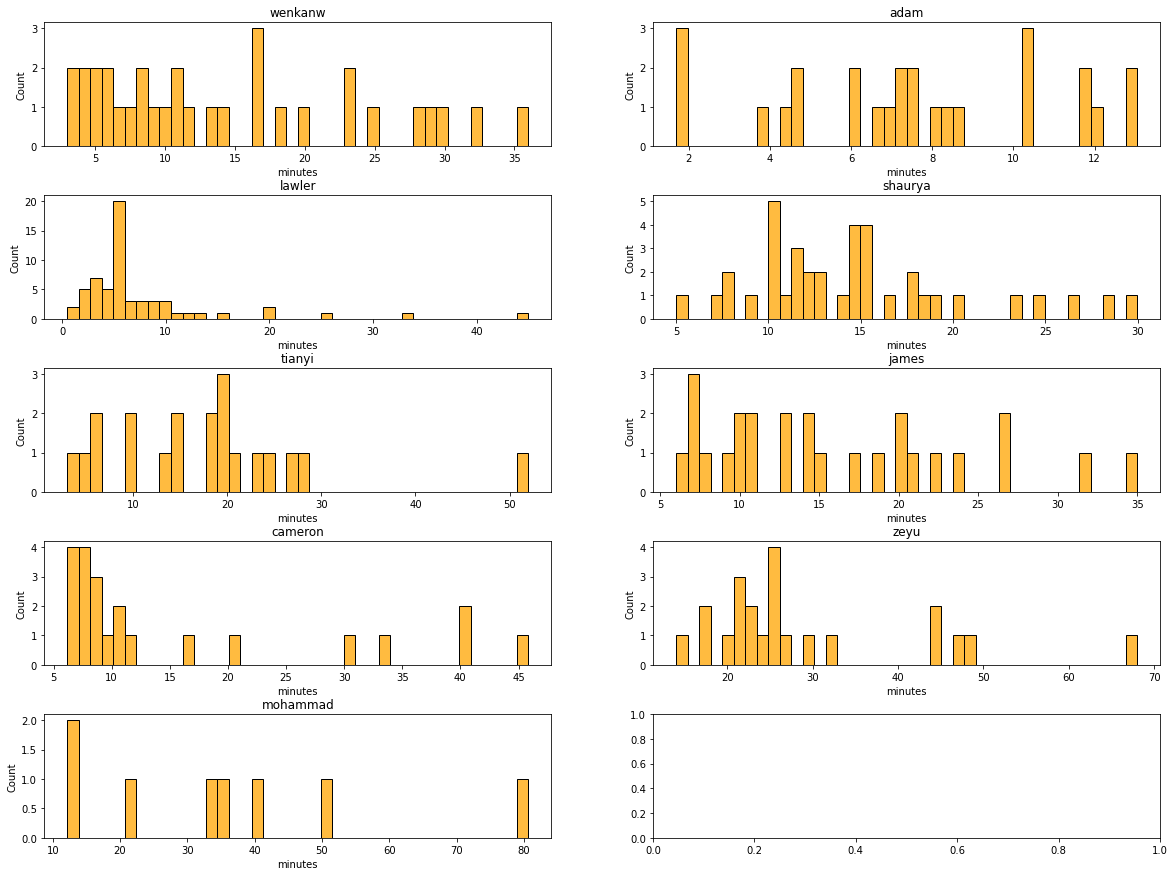

In [65]:
plot()

In [238]:
df = pd.read_csv("../results/dataset_info.csv", index_col = None)
ls = df.columns.tolist()
# df['subject']= [i for i in range(len(df))]#df.index
# ls.insert(0,'subject')
# ls[0] = 'subject'
# df.index= df.dataset
# df =df.drop(columns=[df.index])
df[ls]

,dataset,Days,Total Hours,Meal Counts,Average Meal Counts Per Day,Average Hours Per Meal,Eating Hours,No Eating Hours,Balance Ratio(no_eat/eat)
0,wenkanw,17.0,129.2,32.0,1.9,0.2,7.7,121.5,15.8
1,adam,14.0,125.6,26.0,1.9,0.1,3.3,122.3,37.1
2,lawler,23.0,167.2,60.0,2.6,0.1,7.6,159.6,21.0
3,shaurya,13.0,134.0,38.0,2.9,0.2,9.3,124.7,13.4
4,tianyi,14.0,127.8,20.0,1.4,0.3,5.9,121.9,20.7
5,james,12.0,144.8,26.0,2.2,0.3,7.0,137.8,19.7
6,cameron,10.0,120.4,22.0,2.2,0.3,5.9,114.5,19.4
7,zeyu,12.0,115.5,22.0,1.8,0.5,10.8,104.7,9.7
8,mohammad,6.0,58.4,8.0,1.3,0.6,4.8,53.6,11.2
9,total,121.0,1122.9,254.0,2.1,0.2,62.3,1060.6,17.0


In [46]:
! cat ../data/IndividualData/lawler-data/10.26/10.26-events.txt

START	2020-10-25	19:27:20
Lunch	19:55	20:01	bedroom	Seconds	Alone	CompanyNotEating	bowl of BBQ pulled pork | watching a show on PC
Snack	20:05	20:08	bedroom	Seconds	Alone	CompanyNotEating	poptart pack  | using PC
Dinner	23:52	00:00	bedroom	Seconds	Alone	CompanyNotEating	Wendys biggie bag | using PC
END	2020-10-26	01:09:02






In [8]:
!cat ../data/IndividualData/james-data/1-25-2021/Day4-events.txt

START	2021-01-25	11:48:49
Breakfast	12:09:00	12:28:00	Home	NoSeconds	InCompany	CompanyNotEating	bagel, Granola PB wrap, protein shake | TV
Dinner	19:15:00	19:47:00	Home	Seconds	InCompany	CompanyNotEating	Burrito | TV
END	2021-01-25	23:37:48





In [10]:
! cat ../data/IndividualData/tianyi-data/1-14-21/Shimmer-Data-events.txt

START	2021-01-14	15:42:41
Dinner	20:48	21:40	Home	NoSeconds	Alone	CompanyNotEating	Rice Noodle, Coke Zero | TV, Talking
END	2021-01-14	23:49:41





In [14]:
# meal_ls.sort()
# meal_ls
! head -n 10 ../results/possibility_results/wenkanw/cv_fold_0_group_wenkanw_6min_5slide_proba.csv

day,proba,labels
0,0.20679232,0
0,0.21155065,0
0,0.20643342,0
0,0.20030588,0
0,0.22636288,0
0,0.22972465,0
0,0.22936976,0
0,0.23528284,0
0,0.2389982,0


# Smoothing Effect

In [36]:
nosmooth_data = Person_MealsDataset(person_name= "wenkanw", file_name = "train", winmin = 1,stridesec = 5, normalize_flag=0,smooth_flag=0)
smooth_data = Person_MealsDataset(person_name= "wenkanw", file_name = "train", winmin = 1,stridesec = 5, normalize_flag=0,smooth_flag=1)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-27-20/9-27-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-3-20/10-3-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-10-20/10-10-20.shm
Loading File:  ../data/Individ

In [37]:
nosmooth_sample = nosmooth_data.get_dataset(0,3).data.iloc[0].numpy()
smooth_sample = smooth_data.get_dataset(0,3).data.iloc[0].numpy()

100%|██████████| 3/3 [00:00<00:00, 367.20it/s]


/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


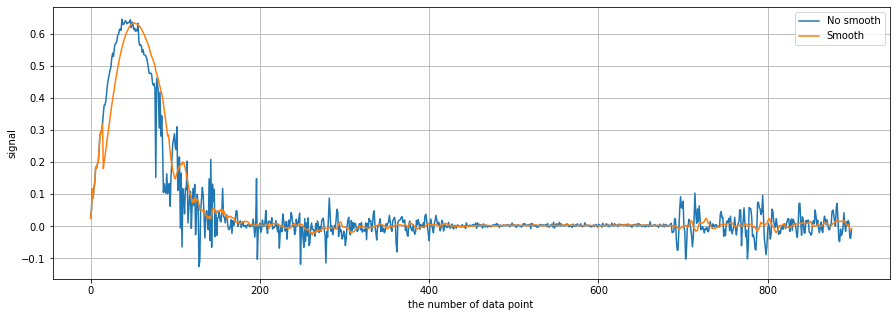

In [79]:

fig, ax = plt.subplots(1, figsize=(15,5))
t= np.arange(0, len(nosmooth_sample[:,0]))
fig= sns.lineplot(t, nosmooth_sample[:,0], ax = ax)
fig = sns.lineplot(t, smooth_sample[:,0], ax= ax)
fig.set(xlabel= "the number of data point",ylabel="signal")

fig.grid()
fig.legend(["No smooth", "Smooth"])
fig_path = "../results/images/"
fig = fig.get_figure()
fig.savefig(fig_path+"smooth", dpi = 80)

# Z-Normalization effect

In [175]:
nonormalized_data = Person_MealsDataset(person_name= "wenkanw", file_name = "train", winmin = 1,stridesec = 5, normalize_flag=0,smooth_flag=0)
normalized_data = Person_MealsDataset(person_name= "wenkanw", file_name = "train", winmin = 1,stridesec = 5, normalize_flag=1,smooth_flag=0)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-27-20/9-27-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-3-20/10-3-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-10-20/10-10-20.shm
Loading File:  ../data/Individ

In [159]:
normalized_data.data[1][:,1]

array([ 7.597046  ,  7.972061  , 10.031198  , ..., -0.36539507,
       -0.35234958, -0.39703488], dtype=float32)

(3402238,)


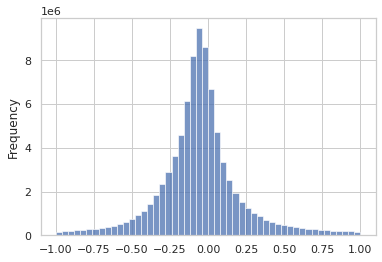

In [214]:
# normal_data = None
# for i in range(len(normalized_data.data)):
#     if i==0:
#         normal_data = normalized_data.data[i][:,1]
#     else:
ls = []
for i in range(10):
    ls.append(normalized_data.data[i][:,0])
normal_data = np.concatenate(ls)
normal_data = normal_data[(normal_data >= -1)&(normal_data<=1)] 
fig= sns.histplot(normal_data,stat='frequency',bins=50)
# fig.set_xlim(-1,1)
print(normal_data.shape)

(3750545,)


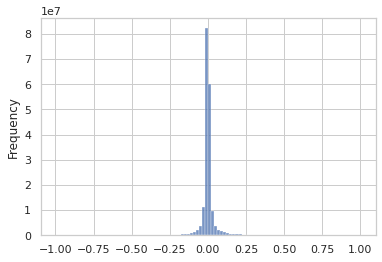

In [212]:
ls = []
for i in range(10):
    ls.append(nonormalized_data.data[i][:,0])
nonormal_data = np.concatenate(ls)
nonormal_data = nonormal_data[(nonormal_data >= -1)&(nonormal_data<=1)] 
fig = sns.histplot(nonormal_data,stat='frequency',bins=100)
# fig .set_xlim(-1,1)
print(nonormal_data.shape)

# Visualize distribution of Eat/ No Eat possibility

In [10]:
# from packages import *
# print(os.path.isfile("."))

In [66]:

def get_episode_output(datasets, threshold= None, use_group_model= False, mode ='cv'):
    """
    Generate probability sequences for all days of data in all dataset
    datasets: a dictionary of dataset with values of Person_MealData class and keys of person's name
    
    threshold: individual threshold. If none, then default to use group threshold 0.8, 0.3
    
    mode: 'cv': use probability  generated from cross validation. 
    
    use_group_model: flag indicating if use probability generated from group model. if False, then use probability from individual model only
    """
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5,shuffle=False)
    output_df = {"dataset":[],"proba_ls":[],"labels_ls":[],"preds_ls":[]}
    names = datasets.keys()
    for person in names:
        print()
        print("Loading {}'s dataset".format(person))
        output_df["dataset"].append(person)
        meal_data = datasets[person]
        result= pd.DataFrame()
        if threshold:
            high_th, low_th = threshold[person][0], threshold[person][1]
        else:
            high_th, low_th = 0.8, 0.3
        # when load cross validation probability        
        if mode =='cv':
            
            days= np.unique(meal_data.data_indices[:,0])
            for fold, (day_train_idx, day_test_idx) in enumerate(kf.split(days)):
                print("Fold: %d"%(fold),"Train on days: ",day_train_idx, "Test on days: ",day_test_idx)
                day_train_idx = day_train_idx.tolist()
                day_test_idx = day_test_idx.tolist()
                model = None
                proba_path = "../results/possibility_results/{}/cv_fold_{}_".format(person,fold)
                if use_group_model:
                    proba_path += "group_"

                partial_result = hysteresis_threshold(model, meal_data,days_ls = day_test_idx, start_threshold=high_th, end_threshold=low_th, winmin = 6, stepsec=5, episode_min = 1.,
                                             load_proba_flag=True,path=proba_path)

                result = result.append(partial_result)
#                 print(partial_result)
        else:
            # when not using probability from cross validation
            proba_path = "../results/possibility_results/"
            if use_group_model:
                    proba_path += "group_"
            result = hysteresis_threshold(model, meal_data,start_threshold=high_th, end_threshold=low_th, winmin = 6, stepsec=5, episode_min = 1.,
                                     load_proba_flag=load_proba_flag,path=proba_path)
            
        # map the threshold result back to the same shape as input sequence
        proba_ls, labels_ls, preds_ls =map_results(meal_data,result)
        output_df["proba_ls"].append(proba_ls)
        output_df["labels_ls"].append(labels_ls)
        output_df["preds_ls"].append(preds_ls)
    return pd.DataFrame(output_df)

In [67]:
from dataset import *
person_ls = ['wenkanw','adam','lawler','shaurya','tianyi','james',"cameron","zeyu","mohammad"]
datasets = create_datasets(names=person_ls)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

In [68]:
output_df = get_episode_output(datasets= datasets, threshold= None, use_group_model= False)
output_df

100%|██████████| 3/3 [00:00<00:00, 322.32it/s]


Loading wenkanw's dataset
Fold: 0 Train on days:  [ 4  5  6  7  8  9 10 11 12 13 14 15 16] Test on days:  [0 1 2 3]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  3  8  9 10 11 12 13 14 15 16] Test on days:  [4 5 6 7]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16] Test on days:  [ 8  9 10]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 14 15 16] Test on days:  [11 12 13]



100%|██████████| 3/3 [00:00<00:00, 470.64it/s]

Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] Test on days:  [14 15 16]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 285.54it/s]


Loading adam's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11 12 13] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12 13] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12 13] Test on days:  [6 7 8]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 12 13] Test on days:  [ 9 10 11]
Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11] Test on days:  [12 13]
Segmentation Completed. 



100%|██████████| 4/4 [00:00<00:00, 621.79it/s]


Loading lawler's dataset
Fold: 0 Train on days:  [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] Test on days:  [0 1 2 3 4]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22] Test on days:  [5 6 7 8 9]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22] Test on days:  [10 11 12 13 14]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 19 20 21 22] Test on days:  [15 16 17 18]
Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] Test on days:  [19 20 21 22]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 360.78it/s]


Loading shaurya's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11 12] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12] Test on days:  [6 7 8]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 11 12] Test on days:  [ 9 10]
Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10] Test on days:  [11 12]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 355.48it/s]


Loading tianyi's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11 12 13] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12 13] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12 13] Test on days:  [6 7 8]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 12 13] Test on days:  [ 9 10 11]
Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11] Test on days:  [12 13]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 270.84it/s]


Loading james's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  8  9 10 11] Test on days:  [6 7]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7 10 11] Test on days:  [8 9]
Segmentation Completed. 
Fold: 4 Train on days:  [0 1 2 3 4 5 6 7 8 9] Test on days:  [10 11]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 92.82it/s]


Loading cameron's dataset
Fold: 0 Train on days:  [2 3 4 5 6 7 8 9] Test on days:  [0 1]
Segmentation Completed. 
Fold: 1 Train on days:  [0 1 4 5 6 7 8 9] Test on days:  [2 3]
Segmentation Completed. 
Fold: 2 Train on days:  [0 1 2 3 6 7 8 9] Test on days:  [4 5]
Segmentation Completed. 
Fold: 3 Train on days:  [0 1 2 3 4 5 8 9] Test on days:  [6 7]
Segmentation Completed. 
Fold: 4 Train on days:  [0 1 2 3 4 5 6 7] Test on days:  [8 9]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 321.64it/s]


Loading zeyu's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  8  9 10 11] Test on days:  [6 7]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7 10 11] Test on days:  [8 9]
Segmentation Completed. 
Fold: 4 Train on days:  [0 1 2 3 4 5 6 7 8 9] Test on days:  [10 11]
Segmentation Completed. 



100%|██████████| 1/1 [00:00<00:00, 282.08it/s]


Loading mohammad's dataset
Fold: 0 Train on days:  [2 3 4 5] Test on days:  [0 1]
Segmentation Completed. 
Fold: 1 Train on days:  [0 1 3 4 5] Test on days:  [2]
Segmentation Completed. 
Fold: 2 Train on days:  [0 1 2 4 5] Test on days:  [3]
Segmentation Completed. 
Fold: 3 Train on days:  [0 1 2 3 5] Test on days:  [4]
Segmentation Completed. 
Fold: 4 Train on days:  [0 1 2 3 4] Test on days:  [5]
Segmentation Completed. 


,dataset,proba_ls,labels_ls,preds_ls
0,wenkanw,"[[0.002624005, 0.002624005, 0.002624005, 0.002...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,adam,"[[0.0264197, 0.0264197, 0.0264197, 0.0264197, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,lawler,"[[0.6156324000000001, 0.6156324000000001, 0.61...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,shaurya,"[[0.8498931999999999, 0.8498931999999999, 0.84...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,tianyi,"[[1.2543125e-05, 1.2543125e-05, 1.2543125e-05,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,james,"[[0.8613601999999999, 0.8613601999999999, 0.86...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
6,cameron,"[[0.7992541999999999, 0.7992541999999999, 0.79...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,zeyu,"[[0.030927597999999997, 0.030927597999999997, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,mohammad,"[[0.019526094, 0.019526094, 0.019526094, 0.019...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [69]:
day = 13
proba_len = len(output_df[output_df['dataset']=='wenkanw'].proba_ls.values[0][day])
labels_len = len(output_df[output_df['dataset']=='wenkanw'].labels_ls.values[0][day])
data_len = len(datasets['wenkanw'].data[day])
proba_len, labels_len, data_len

(384476, 384476, 384476)

In [92]:
def plot_proba_dist(output_df, persons=[], file_name = "individual_prediction_dist",fig_path="../results/images/",dpi=80):
    """
    output_df: 
    """
    def concate_output(proba_ls,labels_ls):
        """
        Concatenate probabilities, labels of all days
        """
        proba_df= np.array([])
        label_df= np.array([])
        for i in range(len(proba_ls)):
                proba_df = np.concatenate((proba_df,proba_ls[i]), axis=None)
                label_df = np.concatenate((label_df,labels_ls[i]), axis=None)
        return proba_df ,label_df
    col = 2
    row = len(persons)//2 + len(persons)%2
    
    figs, axs = plt.subplots(row,col, figsize=(20,20))
    plt.subplots_adjust(hspace =0.4)
    for i, person in enumerate(persons):
        ax = axs[i//2, i%2]
        proba_df = output_df[output_df["dataset"]==person].proba_ls.values[0]
        label_df = output_df[output_df["dataset"]==person].labels_ls.values[0]
        proba_df,label_df = concate_output(proba_df,label_df)

        
        fig =sns.histplot(x=proba_df[label_df==0],common_norm=False,bins=20,stat="probability",ax=ax,color="orange")
        sns.histplot(x=proba_df[label_df==1],common_norm=False,bins=20,stat="probability",ax=ax,color="blue")
        ax.legend(["No Eat","Eat"])
        _ =ax.set(title=person+" dataset"+": Probability of predicted possibility in ",xlabel="Predicted Possibility")
        
        fig = fig.get_figure()
        fig.savefig(fig_path+file_name, dpi = dpi)

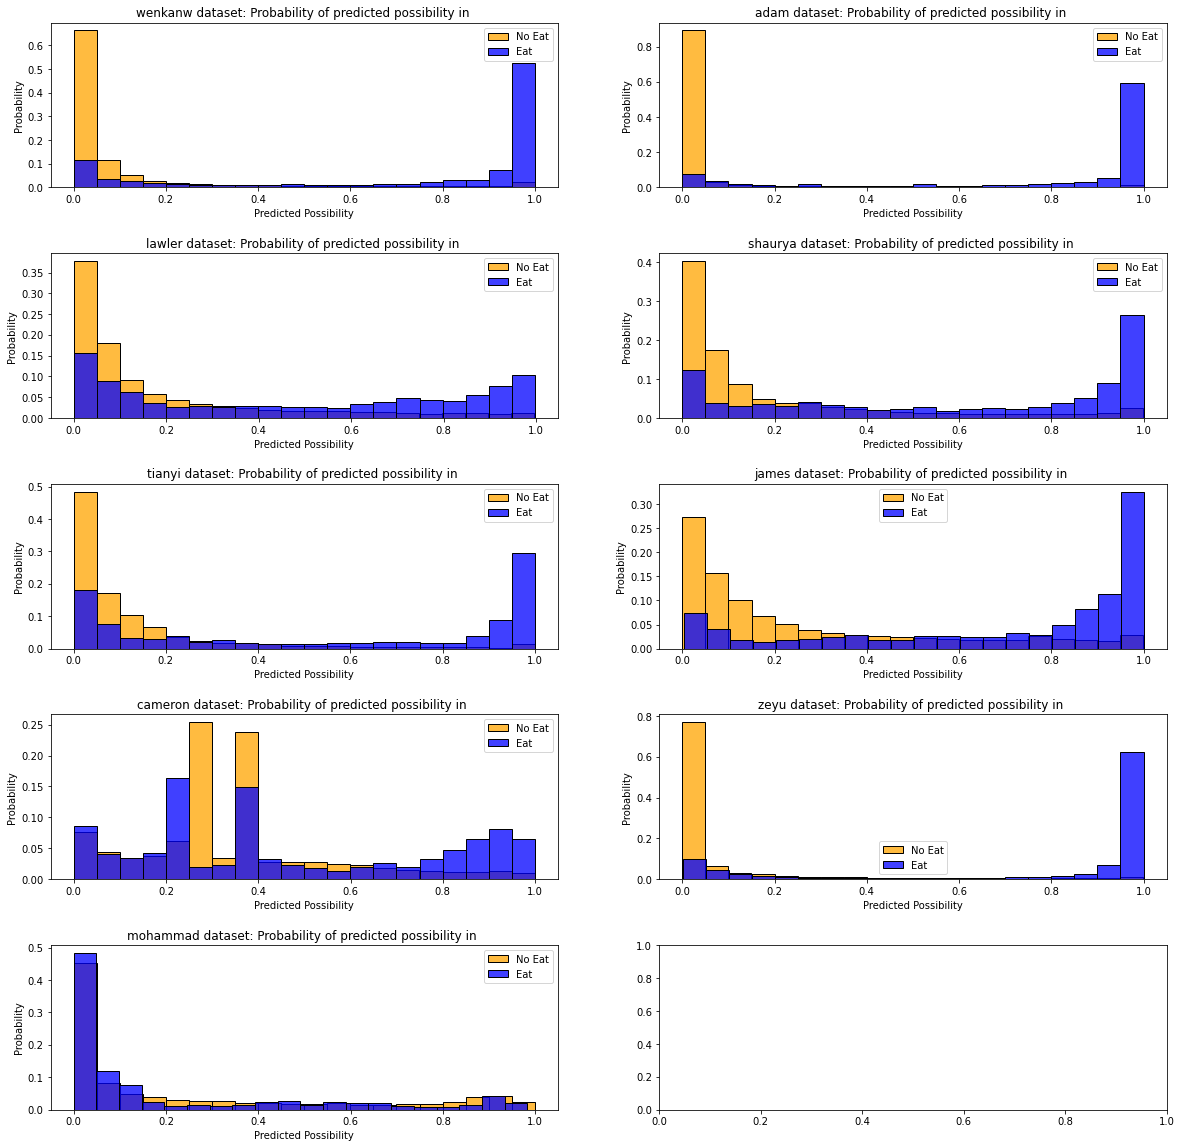

In [94]:
plot_proba_dist(output_df, persons=person_ls, file_name= "individual_prediction_dist")

In [95]:
group_model_output_df = get_episode_output(datasets, threshold= None, use_group_model= True)

100%|██████████| 3/3 [00:00<00:00, 471.06it/s]


Loading wenkanw's dataset
Fold: 0 Train on days:  [ 4  5  6  7  8  9 10 11 12 13 14 15 16] Test on days:  [0 1 2 3]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  3  8  9 10 11 12 13 14 15 16] Test on days:  [4 5 6 7]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16] Test on days:  [ 8  9 10]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 14 15 16] Test on days:  [11 12 13]
Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] Test on days:  [14 15 16]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 281.29it/s]


Loading adam's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11 12 13] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12 13] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12 13] Test on days:  [6 7 8]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 12 13] Test on days:  [ 9 10 11]
Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11] Test on days:  [12 13]
Segmentation Completed. 



100%|██████████| 4/4 [00:00<00:00, 617.99it/s]


Loading lawler's dataset
Fold: 0 Train on days:  [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] Test on days:  [0 1 2 3 4]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22] Test on days:  [5 6 7 8 9]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22] Test on days:  [10 11 12 13 14]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 19 20 21 22] Test on days:  [15 16 17 18]
Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] Test on days:  [19 20 21 22]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 362.23it/s]


Loading shaurya's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11 12] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12] Test on days:  [6 7 8]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 11 12] Test on days:  [ 9 10]
Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10] Test on days:  [11 12]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 353.64it/s]


Loading tianyi's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11 12 13] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12 13] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12 13] Test on days:  [6 7 8]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 12 13] Test on days:  [ 9 10 11]
Segmentation Completed. 
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11] Test on days:  [12 13]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 257.56it/s]


Loading james's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  8  9 10 11] Test on days:  [6 7]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7 10 11] Test on days:  [8 9]
Segmentation Completed. 
Fold: 4 Train on days:  [0 1 2 3 4 5 6 7 8 9] Test on days:  [10 11]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 93.09it/s]


Loading cameron's dataset
Fold: 0 Train on days:  [2 3 4 5 6 7 8 9] Test on days:  [0 1]
Segmentation Completed. 
Fold: 1 Train on days:  [0 1 4 5 6 7 8 9] Test on days:  [2 3]
Segmentation Completed. 
Fold: 2 Train on days:  [0 1 2 3 6 7 8 9] Test on days:  [4 5]
Segmentation Completed. 
Fold: 3 Train on days:  [0 1 2 3 4 5 8 9] Test on days:  [6 7]
Segmentation Completed. 
Fold: 4 Train on days:  [0 1 2 3 4 5 6 7] Test on days:  [8 9]
Segmentation Completed. 



100%|██████████| 2/2 [00:00<00:00, 328.24it/s]


Loading zeyu's dataset
Fold: 0 Train on days:  [ 3  4  5  6  7  8  9 10 11] Test on days:  [0 1 2]
Segmentation Completed. 
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11] Test on days:  [3 4 5]
Segmentation Completed. 
Fold: 2 Train on days:  [ 0  1  2  3  4  5  8  9 10 11] Test on days:  [6 7]
Segmentation Completed. 
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7 10 11] Test on days:  [8 9]
Segmentation Completed. 
Fold: 4 Train on days:  [0 1 2 3 4 5 6 7 8 9] Test on days:  [10 11]
Segmentation Completed. 



100%|██████████| 1/1 [00:00<00:00, 287.01it/s]


Loading mohammad's dataset
Fold: 0 Train on days:  [2 3 4 5] Test on days:  [0 1]
Segmentation Completed. 
Fold: 1 Train on days:  [0 1 3 4 5] Test on days:  [2]
Segmentation Completed. 
Fold: 2 Train on days:  [0 1 2 4 5] Test on days:  [3]
Segmentation Completed. 
Fold: 3 Train on days:  [0 1 2 3 5] Test on days:  [4]
Segmentation Completed. 
Fold: 4 Train on days:  [0 1 2 3 4] Test on days:  [5]
Segmentation Completed. 


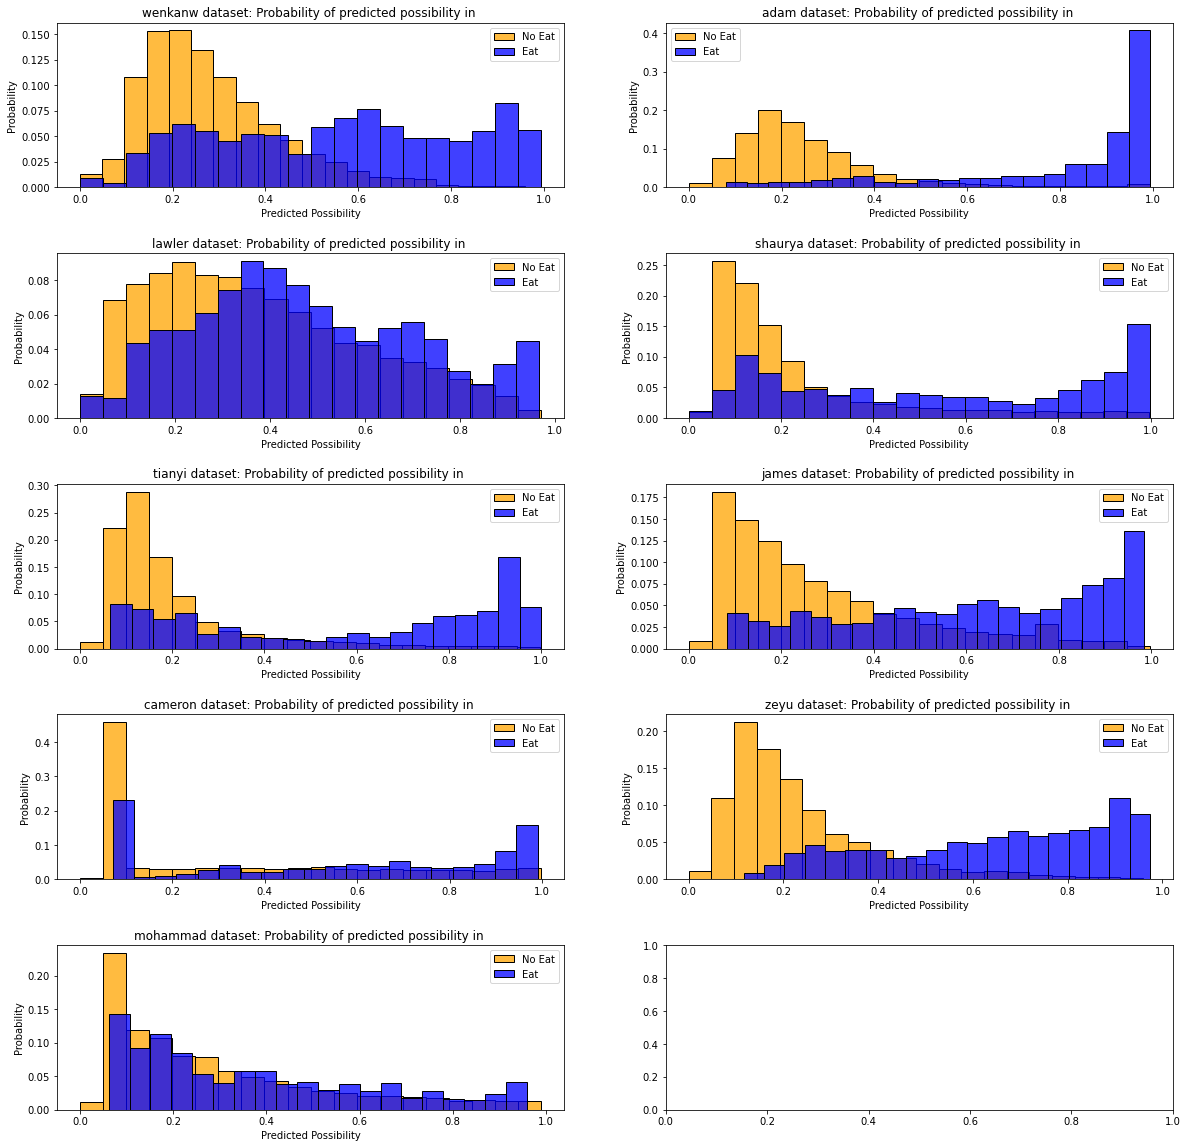

In [96]:
plot_proba_dist(group_model_output_df, persons=person_ls,file_name= "group_prediction_dist")


# Visualize performances of individual models and group model

In [159]:
## load threshold results
threshold_results= pd.read_csv("../results/hysteresis_results/cv_threshold_results.csv")
best_threshold_mtpr=pd.read_csv("../results/hysteresis_results/cv_best_thresholds_mintpr.csv")
best_threshold_mfp=pd.read_csv("../results/hysteresis_results/cv_best_thresholds_maxfp.csv")
best_threshold_ratio=pd.read_csv("../results/hysteresis_results/cv_best_thresholds_ratio.csv")

In [160]:
# read time metric
save_path = "../results/"
time_perf = pd.read_csv(save_path+"time_metrics/final_updated_cv_fold5_time_metrics.csv")
time_perf.rename(columns={"WAcc: GroupModel":"WAcc1: GroupModel","WAcc: Individual-Model":"WAcc1: Individual-Model"},inplace=True)
group_param_episode_perf = pd.read_csv(save_path+"episode_metrics/final_updated_cv_fold5_episode_metrics.csv")

In [161]:
# read improvement of tuning threshold
save_path = "../results/"
ind_perf_mtpr = pd.read_csv(save_path+"episode_metrics/updated_cv_fold5_episode_metrics_individual_param_mtpr.csv")
ind_perf_mfp = pd.read_csv(save_path+"episode_metrics/updated_cv_fold5_episode_metrics_individual_param_mfp.csv")
ind_perf_ratio = pd.read_csv(save_path+"episode_metrics/updated_cv_fold5_episode_metrics_individual_param_ratio.csv")

In [162]:
# rename dataset name
time_perf.replace("average performance",'average',inplace=True)
group_param_episode_perf.replace("average performance",'average',inplace=True)
ind_perf_mtpr.replace("average performance",'average',inplace=True)
ind_perf_mfp.replace("average performance",'average',inplace=True)
ind_perf_ratio.replace("average performance",'average',inplace=True)

In [163]:
# Rename columns of time metric
def rename_col(perf):
    name_dic = {}
    for col in perf.columns:
        if 'WAcc1' in col:
            name_dic[col] = col.replace('WAcc1', "BAcc")
        if 'WAcc2' in col:
            name_dic[col] = col.replace('WAcc2', "WAcc")
    perf.rename(columns=name_dic, inplace = True)


In [164]:
# filter out some subject 
def filer_subject(perf, exclude= [], metric = 'time'):
    mask =None
    exclude.extend(['average', 'average performance'])
    for i in range(len(exclude)):
        if isinstance(mask,type(None) ):
            mask = (perf['dataset'] != exclude[i]).values
        else:
            mask &= (perf['dataset'] != exclude[i]).values
            
    df = perf[mask]
    if metric == "time":
        df = print_time_metrics(df)
    elif metric == "episode":
        df = print_episode_metrics(df)
    elif metric == "threshold":
        pass
    df.replace("average performance",'average',inplace=True)
    return df

In [165]:
# exclude some persons and recalculate average performance
exclude_ls = ['mohammad']
time_perf_ex = filer_subject(time_perf, exclude= exclude_ls, metric = 'time')
group_param_episode_perf_ex= filer_subject(group_param_episode_perf, exclude= exclude_ls, metric = 'episode')
ind_perf_mtpr_ex = filer_subject(ind_perf_mtpr, exclude= exclude_ls, metric = 'episode')
ind_perf_mfp_ex = filer_subject(ind_perf_mfp, exclude= exclude_ls, metric = 'episode')
ind_perf_ratio_ex = filer_subject(ind_perf_ratio, exclude= exclude_ls, metric = 'episode')
threshold_results_ex = filer_subject(threshold_results, exclude= exclude_ls , metric = 'threshold')

In [216]:
rename_col(time_perf_ex)
time_perf_ex

,dataset,win(sec),BAcc: GroupModel,WAcc: GroupModel,BAcc: Individual-Model,WAcc: Individual-Model,F1: GroupModel,F1: Individual-Model,Precision: GroupModel,Precision: Individual-Model,Recall: GroupModel,Recall: Individual-Model,Acc: GroupModel,Acc: Individual-Model
0,wenkanw,360,0.779,0.774,0.900,0.897,0.423,0.639,0.319,0.520,0.649,0.853,0.893,0.942
1,adam,360,0.956,0.956,0.959,0.958,0.433,0.625,0.284,0.484,0.983,0.949,0.931,0.968
2,lawler,360,0.605,0.611,0.721,0.722,0.132,0.258,0.076,0.166,0.494,0.578,0.707,0.851
3,shaurya,360,0.759,0.757,0.766,0.763,0.409,0.402,0.308,0.295,0.624,0.654,0.874,0.862
4,tianyi,360,0.833,0.825,0.843,0.837,0.456,0.474,0.341,0.359,0.736,0.760,0.920,0.918
5,james,360,0.787,0.786,0.799,0.795,0.303,0.311,0.194,0.206,0.730,0.770,0.838,0.825
6,cameron,360,0.641,0.688,0.614,0.684,0.113,0.120,0.062,0.072,0.659,0.465,0.631,0.756
7,zeyu,360,0.837,0.843,0.885,0.893,0.611,0.737,0.521,0.687,0.743,0.812,0.916,0.947
8,average,-,0.775,0.780,0.811,0.819,0.360,0.446,0.263,0.349,0.702,0.730,0.839,0.884


In [167]:
rename_col(time_perf)
time_perf

,dataset,win(sec),BAcc: GroupModel,WAcc: GroupModel,BAcc: Individual-Model,WAcc: Individual-Model,F1: GroupModel,F1: Individual-Model,Precision: GroupModel,Precision: Individual-Model,Recall: GroupModel,Recall: Individual-Model,Acc: GroupModel,Acc: Individual-Model
0,wenkanw,360,0.779,0.774,0.900,0.897,0.423,0.639,0.319,0.520,0.649,0.853,0.893,0.942
1,adam,360,0.956,0.956,0.959,0.958,0.433,0.625,0.284,0.484,0.983,0.949,0.931,0.968
2,lawler,360,0.605,0.611,0.721,0.722,0.132,0.258,0.076,0.166,0.494,0.578,0.707,0.851
3,shaurya,360,0.759,0.757,0.766,0.763,0.409,0.402,0.308,0.295,0.624,0.654,0.874,0.862
4,tianyi,360,0.833,0.825,0.843,0.837,0.456,0.474,0.341,0.359,0.736,0.760,0.920,0.918
5,james,360,0.787,0.786,0.799,0.795,0.303,0.311,0.194,0.206,0.730,0.770,0.838,0.825
6,cameron,360,0.641,0.688,0.614,0.684,0.113,0.120,0.062,0.072,0.659,0.465,0.631,0.756
7,zeyu,360,0.837,0.843,0.885,0.893,0.611,0.737,0.521,0.687,0.743,0.812,0.916,0.947
8,mohammad,360,0.639,0.621,0.556,0.518,0.153,0.059,0.110,0.041,0.292,0.188,0.778,0.712
9,average,-,0.760,0.762,0.783,0.785,0.337,0.403,0.246,0.314,0.657,0.670,0.832,0.865


In [154]:
group_param_episode_perf

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.594,0.613,0.368,31.000,19.000,19.000,7.000,1.000,13.000
1,adam,14,3,26,360,0.923,0.923,0.417,0.375,24.000,24.000,10.000,9.000,2.000,2.000
2,lawler,23,7,60,360,0.667,0.333,1.200,2.800,40.000,20.000,48.000,56.000,20.000,40.000
3,shaurya,13,9,38,360,0.763,0.763,1.759,0.897,29.000,29.000,51.000,26.000,9.000,9.000
4,tianyi,14,5,20,360,0.600,0.750,2.250,1.400,12.000,15.000,27.000,21.000,8.000,5.000
5,james,12,6,26,360,0.923,0.885,2.083,1.739,24.000,23.000,50.000,40.000,2.000,3.000
6,cameron,10,5,22,360,0.636,0.773,4.786,3.882,14.000,17.000,67.000,66.000,8.000,5.000
7,zeyu,12,10,22,360,0.909,0.864,0.900,0.789,20.000,19.000,18.000,15.000,2.000,3.000
8,mohammad,6,4,8,360,0.625,0.750,6.200,4.667,5.000,6.000,31.000,28.000,3.000,2.000
9,average,-,-,-,-,0.779,0.737,2.245,1.880,22.111,19.111,35.667,29.778,6.111,9.111


In [155]:
ind_perf_mtpr

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.594,0.484,0.368,31.000,19.000,15.000,7.000,1.0,13.000
1,adam,14,3,26,360,0.923,0.923,0.292,0.375,24.000,24.000,7.000,9.000,2.0,2.000
2,lawler,23,7,60,360,0.817,0.333,1.735,2.800,49.000,20.000,85.000,56.000,11.0,40.000
3,shaurya,13,9,38,360,0.816,0.763,1.774,0.897,31.000,29.000,55.000,26.000,7.0,9.000
4,tianyi,14,5,20,360,0.800,0.750,2.562,1.400,16.000,15.000,41.000,21.000,4.0,5.000
5,james,12,6,26,360,0.923,0.885,1.458,1.739,24.000,23.000,35.000,40.000,2.0,3.000
6,cameron,10,5,22,360,0.818,0.773,1.833,3.882,18.000,17.000,33.000,66.000,4.0,5.000
7,zeyu,12,10,22,360,0.909,0.864,0.650,0.789,20.000,19.000,13.000,15.000,2.0,3.000
8,mohammad,6,4,8,360,0.625,0.750,6.600,4.667,5.000,6.000,33.000,28.000,3.0,2.000
9,average,-,-,-,-,0.844,0.737,1.932,1.880,24.222,19.111,35.222,29.778,4.0,9.111


In [156]:
ind_perf_mfp

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.594,1.000,0.368,31.000,19.000,31.000,7.000,1.000,13.000
1,adam,14,3,26,360,0.962,0.923,0.640,0.375,25.000,24.000,16.000,9.000,1.000,2.000
2,lawler,23,7,60,360,0.583,0.333,1.000,2.800,35.000,20.000,35.000,56.000,25.000,40.000
3,shaurya,13,9,38,360,0.737,0.763,1.214,0.897,28.000,29.000,34.000,26.000,10.000,9.000
4,tianyi,14,5,20,360,0.600,0.750,1.417,1.400,12.000,15.000,17.000,21.000,8.000,5.000
5,james,12,6,26,360,0.923,0.885,1.458,1.739,24.000,23.000,35.000,40.000,2.000,3.000
6,cameron,10,5,22,360,0.773,0.773,1.588,3.882,17.000,17.000,27.000,66.000,5.000,5.000
7,zeyu,12,10,22,360,0.909,0.864,0.950,0.789,20.000,19.000,19.000,15.000,2.000,3.000
8,mohammad,6,4,8,360,0.625,0.750,4.600,4.667,5.000,6.000,23.000,28.000,3.000,2.000
9,average,-,-,-,-,0.787,0.737,1.541,1.880,21.889,19.111,26.333,29.778,6.333,9.111


In [157]:
ind_perf_ratio

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.594,0.484,0.368,31.000,19.000,15.000,7.000,1.0,13.000
1,adam,14,3,26,360,0.923,0.923,0.292,0.375,24.000,24.000,7.000,9.000,2.0,2.000
2,lawler,23,7,60,360,0.650,0.333,1.077,2.800,39.000,20.000,42.000,56.000,21.0,40.000
3,shaurya,13,9,38,360,0.737,0.763,1.214,0.897,28.000,29.000,34.000,26.000,10.0,9.000
4,tianyi,14,5,20,360,0.600,0.750,1.417,1.400,12.000,15.000,17.000,21.000,8.0,5.000
5,james,12,6,26,360,0.923,0.885,1.458,1.739,24.000,23.000,35.000,40.000,2.0,3.000
6,cameron,10,5,22,360,0.773,0.773,1.588,3.882,17.000,17.000,27.000,66.000,5.0,5.000
7,zeyu,12,10,22,360,0.909,0.864,0.650,0.789,20.000,19.000,13.000,15.000,2.0,3.000
8,mohammad,6,4,8,360,0.625,0.750,4.600,4.667,5.000,6.000,23.000,28.000,3.0,2.000
9,average,-,-,-,-,0.790,0.737,1.420,1.880,22.222,19.111,23.667,29.778,6.0,9.111


In [168]:
#excluded subjects
rename_col(time_perf_ex)
time_perf_ex

,dataset,win(sec),BAcc: GroupModel,WAcc: GroupModel,BAcc: Individual-Model,WAcc: Individual-Model,F1: GroupModel,F1: Individual-Model,Precision: GroupModel,Precision: Individual-Model,Recall: GroupModel,Recall: Individual-Model,Acc: GroupModel,Acc: Individual-Model
0,wenkanw,360,0.779,0.774,0.900,0.897,0.423,0.639,0.319,0.520,0.649,0.853,0.893,0.942
1,adam,360,0.956,0.956,0.959,0.958,0.433,0.625,0.284,0.484,0.983,0.949,0.931,0.968
2,lawler,360,0.605,0.611,0.721,0.722,0.132,0.258,0.076,0.166,0.494,0.578,0.707,0.851
3,shaurya,360,0.759,0.757,0.766,0.763,0.409,0.402,0.308,0.295,0.624,0.654,0.874,0.862
4,tianyi,360,0.833,0.825,0.843,0.837,0.456,0.474,0.341,0.359,0.736,0.760,0.920,0.918
5,james,360,0.787,0.786,0.799,0.795,0.303,0.311,0.194,0.206,0.730,0.770,0.838,0.825
6,cameron,360,0.641,0.688,0.614,0.684,0.113,0.120,0.062,0.072,0.659,0.465,0.631,0.756
7,zeyu,360,0.837,0.843,0.885,0.893,0.611,0.737,0.521,0.687,0.743,0.812,0.916,0.947
8,average,-,0.775,0.780,0.811,0.819,0.360,0.446,0.263,0.349,0.702,0.730,0.839,0.884


In [169]:
group_param_episode_perf_ex

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.594,0.613,0.368,31.00,19.00,19.00,7.0,1.0,13.0
1,adam,14,3,26,360,0.923,0.923,0.417,0.375,24.00,24.00,10.00,9.0,2.0,2.0
2,lawler,23,7,60,360,0.667,0.333,1.200,2.800,40.00,20.00,48.00,56.0,20.0,40.0
3,shaurya,13,9,38,360,0.763,0.763,1.759,0.897,29.00,29.00,51.00,26.0,9.0,9.0
4,tianyi,14,5,20,360,0.600,0.750,2.250,1.400,12.00,15.00,27.00,21.0,8.0,5.0
5,james,12,6,26,360,0.923,0.885,2.083,1.739,24.00,23.00,50.00,40.0,2.0,3.0
6,cameron,10,5,22,360,0.636,0.773,4.786,3.882,14.00,17.00,67.00,66.0,8.0,5.0
7,zeyu,12,10,22,360,0.909,0.864,0.900,0.789,20.00,19.00,18.00,15.0,2.0,3.0
8,average,-,-,-,-,0.799,0.736,1.751,1.531,24.25,20.75,36.25,30.0,6.5,10.0


In [170]:
time_perf_ex.to_csv(save_path+"time_metrics/final_updated_cv_fold5_time_metrics_ex.csv",index= False)
group_param_episode_perf_ex.to_csv(save_path+"episode_metrics/final_updated_cv_fold5_episode_metrics_ex.csv",index=False)
ind_perf_mtpr_ex.to_csv(save_path+"episode_metrics/updated_cv_fold5_episode_metrics_individual_param_mtpr_ex.csv",index= False)
ind_perf_mfp_ex.to_csv(save_path+"episode_metrics/updated_cv_fold5_episode_metrics_individual_param_mfp_ex.csv",index= False)
ind_perf_ratio_ex.to_csv(save_path+"episode_metrics/updated_cv_fold5_episode_metrics_individual_param_ratio_ex.csv",index= False)
threshold_results_ex.to_csv(save_path+"episode_metrics/updated_cv_fold5_episode_metrics_individual_param_mtpr_ex.csv",index= False)

# Plot Effect of T_s and T_e

Fixed Te, Change Ts


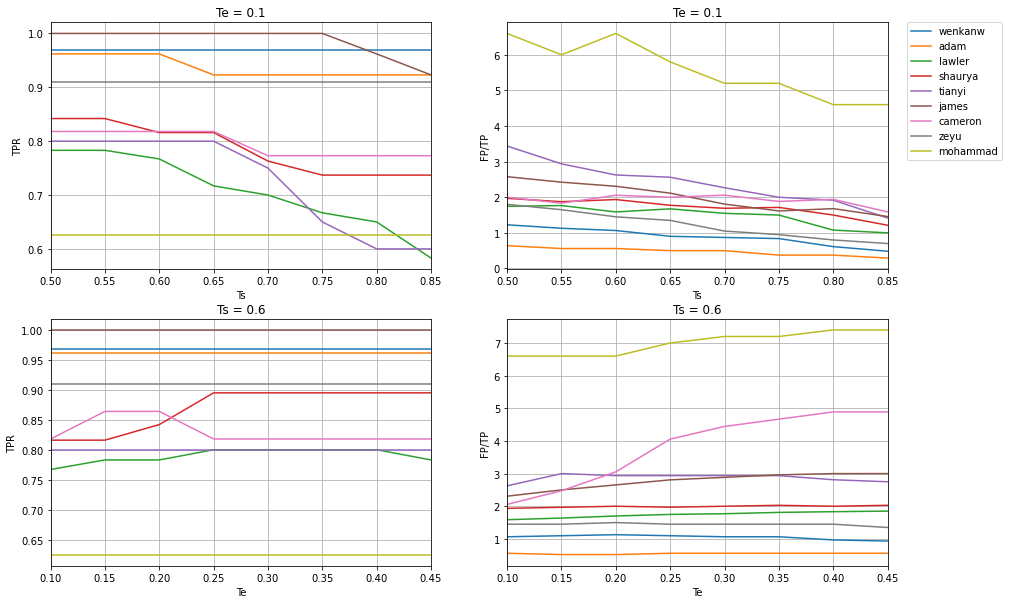

In [18]:
from visualization import *
fig_ts, fig_te = plot_threshold_results(threshold_results,te_val = 0.1, ts_val=0.6, figsize = (15, 10),grid=True)
save_figs(fig_ts, fig_te, dpi=80,fig_path = "../results/images/",prefix="1_")

Fixed Te, Change Ts


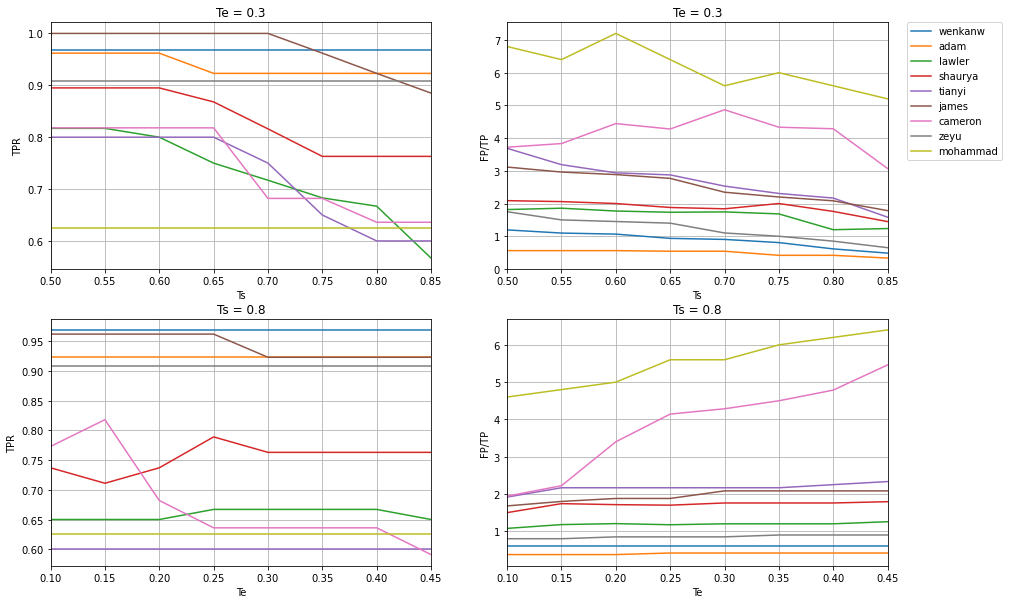

In [19]:
fig_ts, fig_te = plot_threshold_results(threshold_results,te_val = 0.3, ts_val=0.8, figsize = (15, 10),grid=True)
save_figs(fig_ts, fig_te, dpi=80,fig_path = "../results/images/",prefix="2_")

# Excluded some subjects

Fixed Te, Change Ts


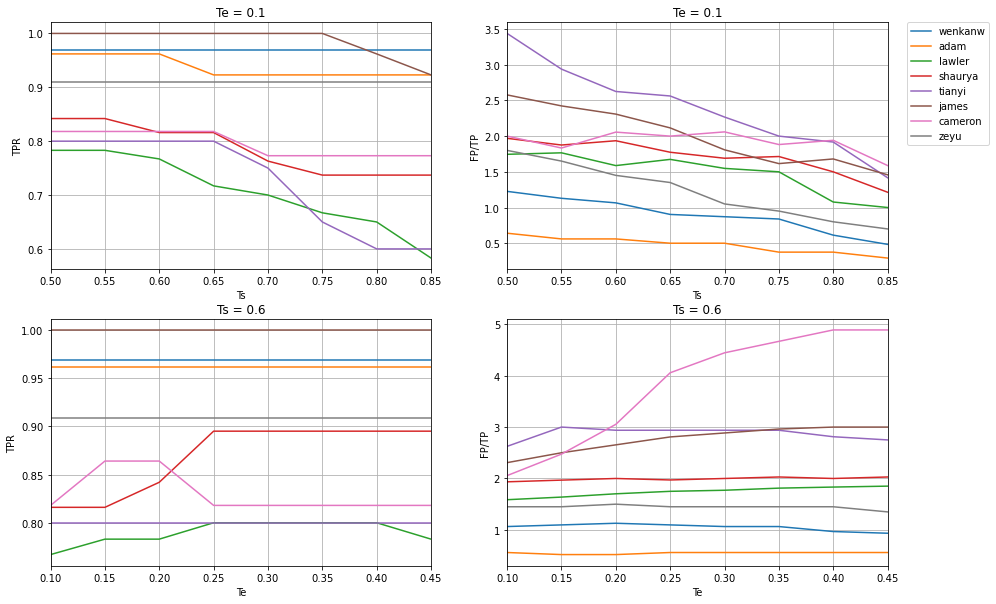

In [171]:
from visualization import *
fig_ts, fig_te = plot_threshold_results(threshold_results_ex,te_val = 0.1, ts_val=0.6, figsize = (15, 10),grid=True)
save_figs(fig_ts, fig_te, dpi=80,fig_path = "../results/images/",prefix="1_ex_")

Fixed Te, Change Ts


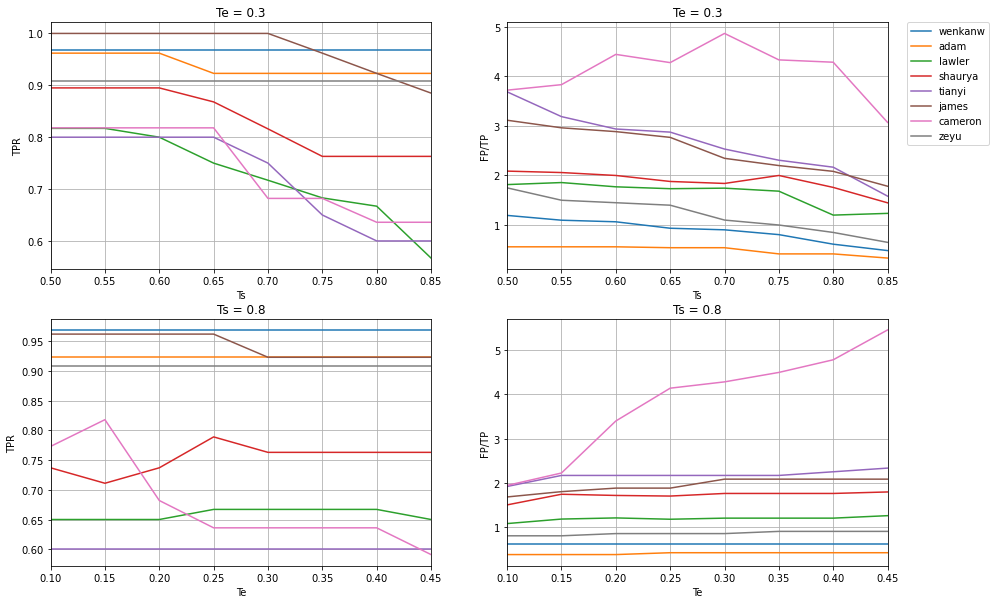

In [172]:
fig_ts, fig_te = plot_threshold_results(threshold_results_ex,te_val = 0.3, ts_val=0.8, figsize = (15, 10),grid=True)
save_figs(fig_ts, fig_te, dpi=80,fig_path = "../results/images/",prefix="2_ex_")

# Plot Performance: Time Metric and Episode Metric

In [184]:
def plot_perf(data, metrics=[], fig_path = "../results/images/", file_name ="",dpi= 80):
    df1 = pd.DataFrame(columns=["dataset",'model'])
    df2 = pd.DataFrame(columns=["dataset",'model'])
    df3 = pd.DataFrame(columns=["dataset",'model'])
    df1.dataset= data['dataset']
    df2.dataset= data['dataset']
    df3.dataset= data['dataset']
    fig, ax = plt.subplots(len(metrics), figsize=(10,10))
    for i, m in enumerate(metrics):
        col_name= None
        for col in data.columns.tolist():
            #print(col,m)
            if m.lower() in col.lower() and 'group' in col.lower():
                df1[m] = data[col].copy()
                df1.loc[:,'model'] ='group'
            elif m.lower() in col.lower() and 'individual' in col.lower():
                df2[m] = data[col].copy()
                df2.loc[:,'model'] ='individual'
                
#                 df2 = data[['dataset',col]]
#                 df2.rename(columns={col:m}, inplace=True)
#                 df2['model'].loc[:] ='individual'
        if not df1.empty and not df2.empty:
            df1 = df1[df1['dataset']!='average']
            df2 = df2[df2['dataset']!='average']
            df3=  pd.concat([df1,df2])
            df3.sort_values(by=[m],inplace=True)
            
            bar_fig =sns.barplot(data=df3,x= 'dataset',y=m,hue='model',ax=ax[i])
            
            bar_fig = bar_fig.get_figure()
            bar_fig.savefig(fig_path+file_name, dpi = dpi)
            
        else:
            print("Metrics not found")
    return pd.concat([df1,df2])

def plot_avg_perf()

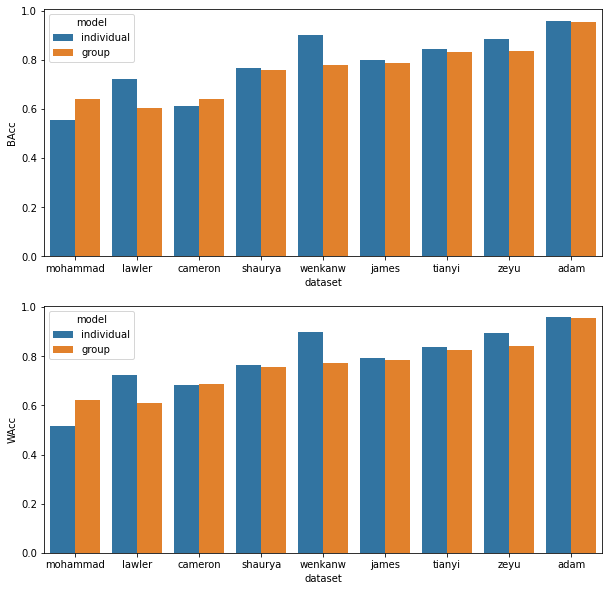

In [185]:
time_df = plot_perf(time_perf, metrics=['BAcc','WAcc'], file_name="time_perf")

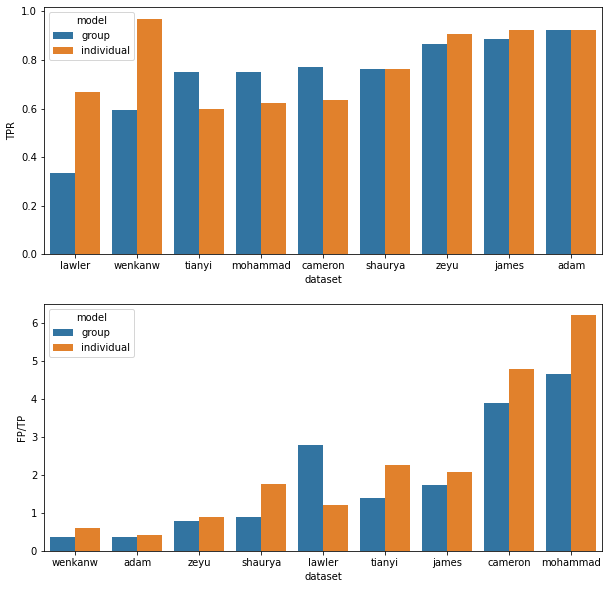

In [186]:
group_episode_df = plot_perf(group_param_episode_perf, metrics=['TPR','FP/TP'], file_name="episode_group_param_perf")

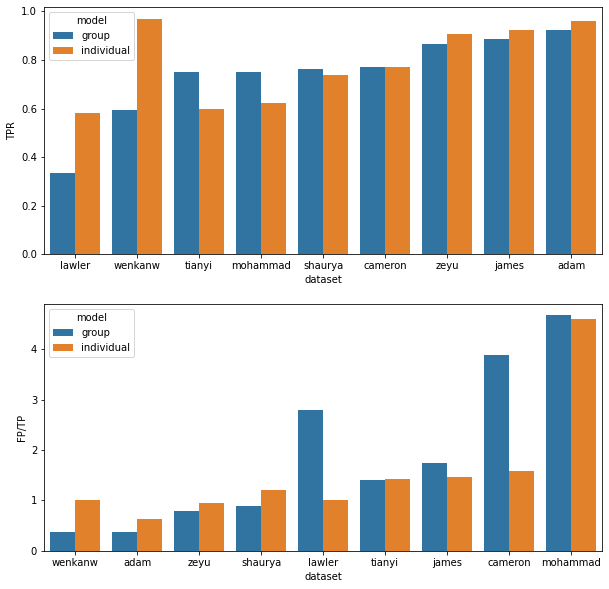

In [187]:
ind_episode_df_mfp = plot_perf(ind_perf_mfp, metrics=['TPR','FP/TP'],file_name="episode_mfp_param_perf")

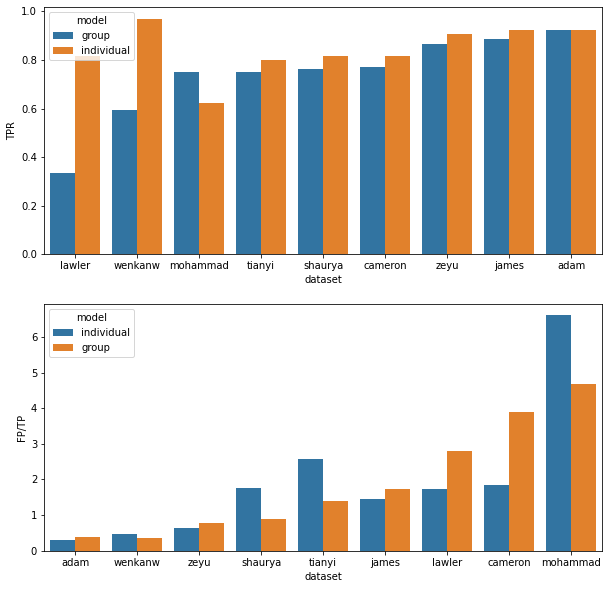

In [188]:
ind_episode_df_mtpr = plot_perf(ind_perf_mtpr, metrics=['TPR','FP/TP'],file_name="episode_mtpr_param_perf")

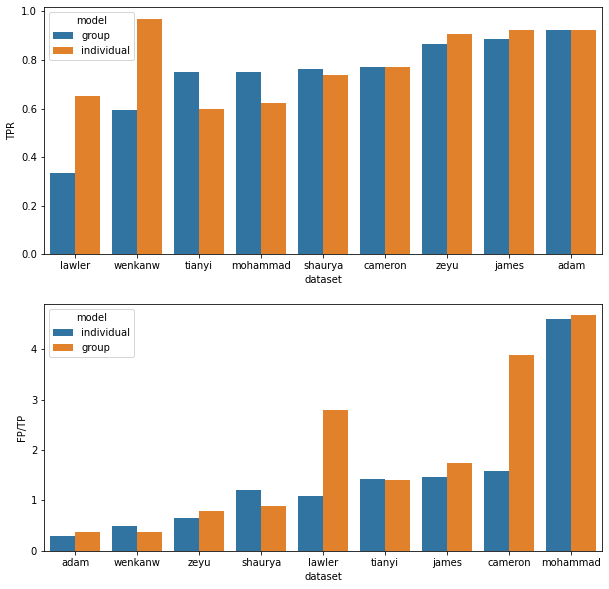

In [189]:
ind_episode_df_ratio = plot_perf(ind_perf_ratio, metrics=['TPR','FP/TP'],file_name="episode_ratio_param_perf")

# After excluding some subjects

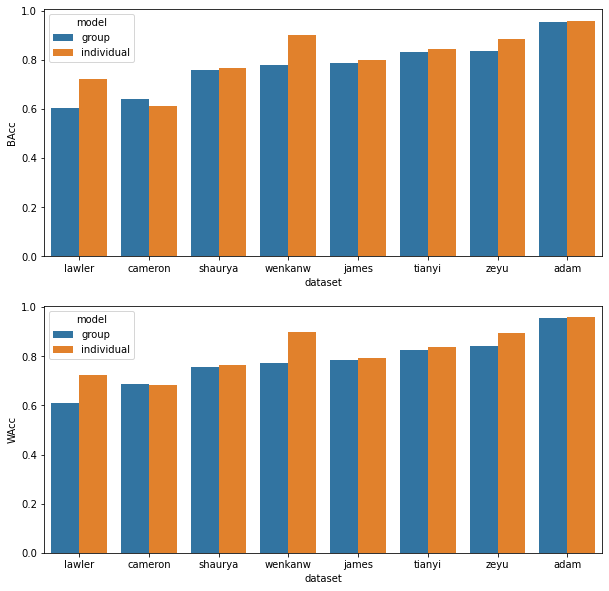

In [190]:
time_df = plot_perf(time_perf_ex, metrics=['BAcc','WAcc'], file_name="time_perf_ex")

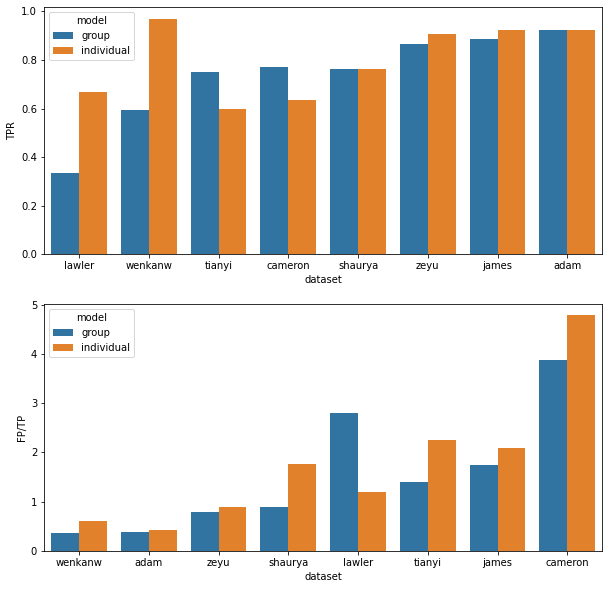

In [191]:
group_episode_df = plot_perf(group_param_episode_perf_ex, metrics=['TPR','FP/TP'], file_name="episode_group_param_perf_ex")

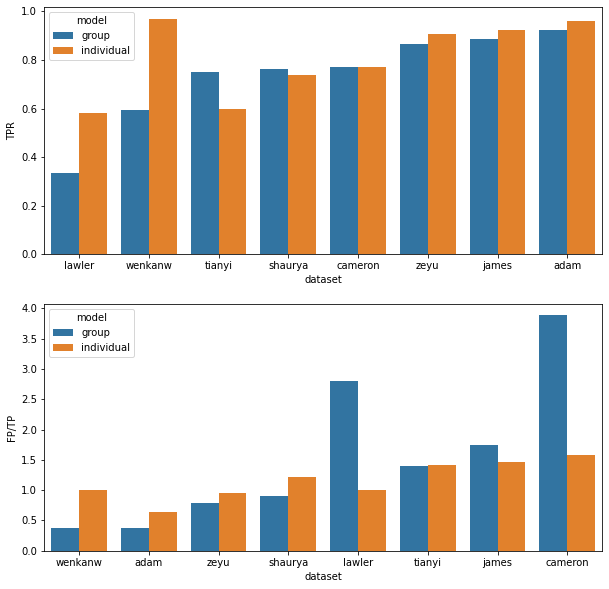

In [192]:
ind_episode_df_mfp = plot_perf(ind_perf_mfp_ex, metrics=['TPR','FP/TP'],file_name="episode_mfp_param_perf_ex")

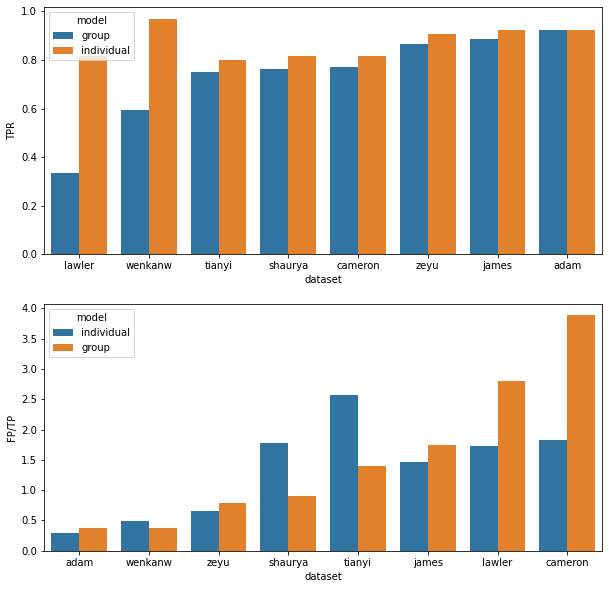

In [193]:
ind_episode_df_mtpr = plot_perf(ind_perf_mtpr_ex, metrics=['TPR','FP/TP'],file_name="episode_mtpr_param_perf_ex")

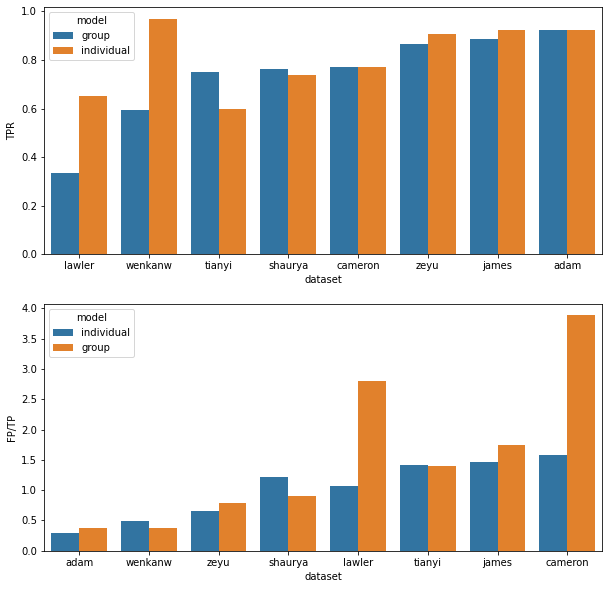

In [194]:
ind_episode_df_ratio = plot_perf(ind_perf_ratio_ex, metrics=['TPR','FP/TP'],file_name="episode_ratio_param_perf_ex")

In [41]:
def compute_improvement(df1, df2, fig_path="../results/images/",file_name="",dpi=80):
    """
    df1 is the performance of using individual parameters
    df2 is the performance of using group parameters
    """
    # compare with individual models using group parameters
    tpr1_individual = df1[['TPR: Individual-Model']].to_numpy().squeeze()
    tpr2_individual = df2[['TPR: Individual-Model']].to_numpy().squeeze()
    
    fp1_individual = df1[['FP/TP: Individual-Model']].to_numpy().squeeze() 
    fp2_individual = df2[['FP/TP: Individual-Model']].to_numpy().squeeze() 
    
    tpr_group =  df1[['TPR: GroupModel']].to_numpy().squeeze()
    fp_group =  df1[['FP/TP: GroupModel']].to_numpy().squeeze()
    
    tpr_improve = (tpr1_individual-tpr2_individual )*100/tpr2_individual
    fp_improve = -(fp1_individual-fp2_individual)*100/fp2_individual
    
    # compare with group models after using individual parameters
    tpr_compare = (tpr1_individual - tpr_group)*100/tpr_group
    fp_compare = -(fp1_individual - fp_group)*100/ fp_group
    
    fig, ax = plt.subplots(2,2,figsize =(20,10))
    fig1 = sns.barplot(x = df1['dataset'], y =tpr_improve, ax= ax[0,0])
    fig2 = sns.barplot(x = df1['dataset'], y =fp_improve, ax= ax[0,1])
    fig3 = sns.barplot(x = df1['dataset'], y =tpr_compare, ax= ax[1,0])
    fig4 = sns.barplot(x = df1['dataset'], y =fp_compare, ax= ax[1,1])
    fig1.set_title("TPR improvement(%): individual-individual")
    fig2.set_title("FP/TP improvement(%): individual-individual")
    fig3.set_title("TPR improvement(%): individual-Group")
    fig4.set_title("FP/TP improvement(%): individual-Group")
    
    fig4 = fig4.get_figure()
    fig4.savefig(fig_path+file_name, dpi = dpi)
    return fp_compare


array([-31.52173913,  22.13333333,  38.03571429, -97.7703456 ,
       -83.        ,  16.1587119 ,  52.7820711 ,  17.61723701,
       -41.41847011,  -2.76595745])

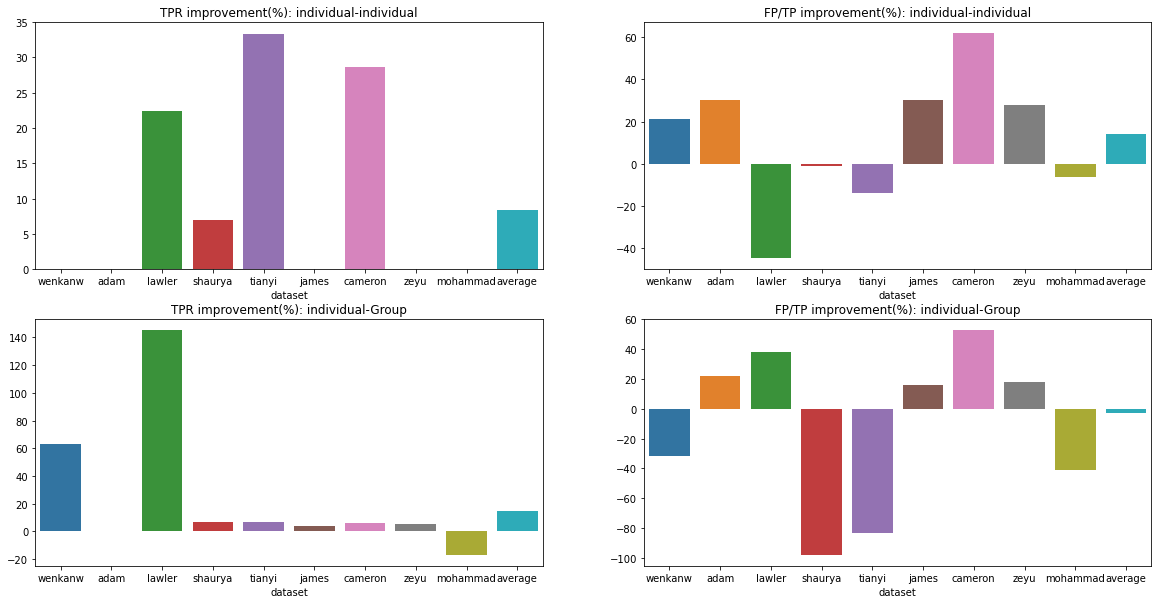

In [42]:
# improve TPR rate, but decreate FP/TP performance
compute_improvement(ind_perf_mtpr,group_param_episode_perf,file_name = 'episode_improvement_mtpr')

array([-171.73913043,  -70.66666667,   64.28571429,  -35.3400223 ,
         -1.21428571,   16.1587119 ,   59.0932509 ,  -20.40557668,
          1.43561174,   18.03191489])

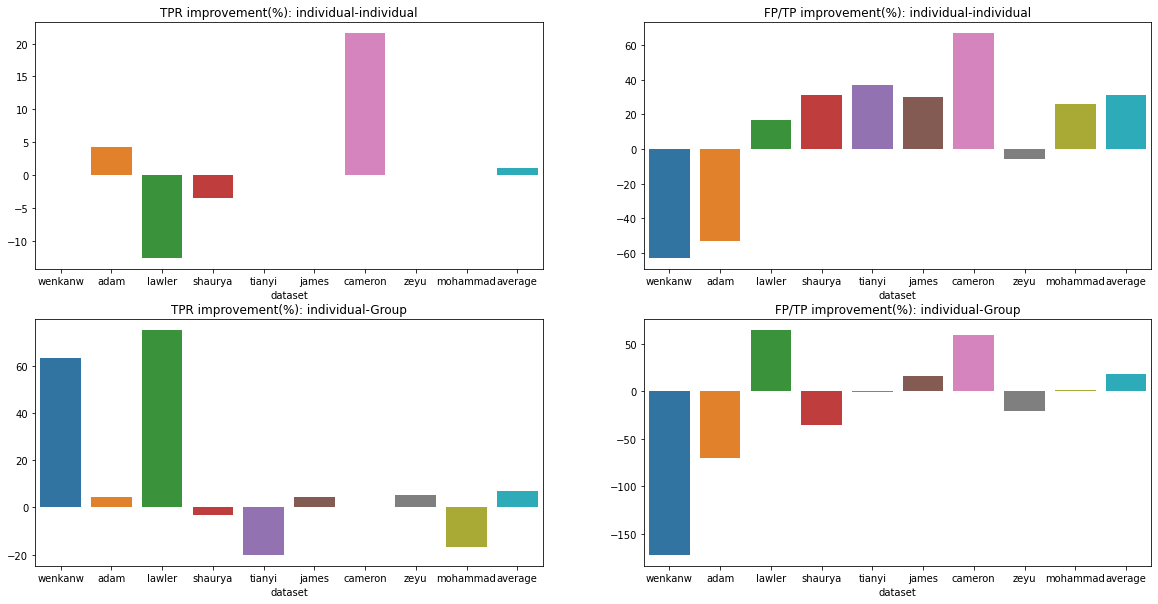

In [43]:
# improve FP/TP rate, 
compute_improvement(ind_perf_mfp,group_param_episode_perf,file_name = 'episode_improvement_mfp')

array([-31.52173913,  22.13333333,  61.53571429, -35.3400223 ,
        -1.21428571,  16.1587119 ,  59.0932509 ,  17.61723701,
         1.43561174,  24.46808511])

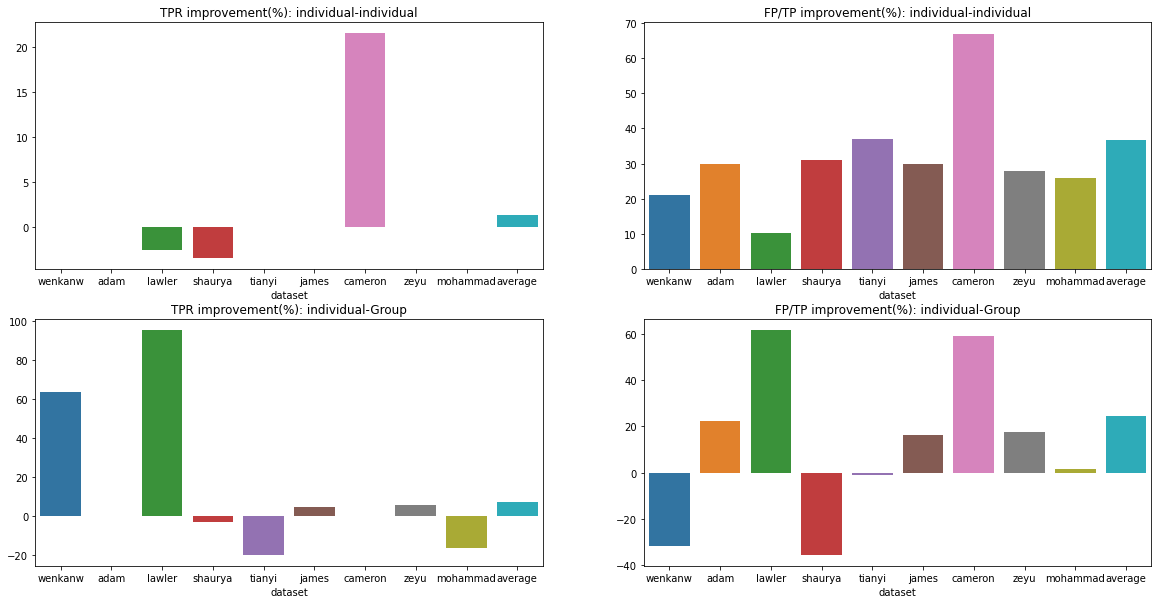

In [44]:
# find the thresholds that maximize  (TP )/(FN + FP + TP)
compute_improvement(ind_perf_ratio,group_param_episode_perf,file_name = 'episode_improvement_ratio')

In [31]:
ind_perf_ratio

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.594,0.484,0.368,31.000,19.000,15.000,7.000,1.0,13.000
1,adam,14,3,26,360,0.923,0.923,0.292,0.375,24.000,24.000,7.000,9.000,2.0,2.000
2,lawler,23,7,60,360,0.650,0.333,1.077,2.800,39.000,20.000,42.000,56.000,21.0,40.000
3,shaurya,13,9,38,360,0.737,0.763,1.214,0.897,28.000,29.000,34.000,26.000,10.0,9.000
4,tianyi,14,5,20,360,0.600,0.750,1.417,1.400,12.000,15.000,17.000,21.000,8.0,5.000
5,james,12,6,26,360,0.923,0.885,1.458,1.739,24.000,23.000,35.000,40.000,2.0,3.000
6,cameron,10,5,22,360,0.773,0.773,1.588,3.882,17.000,17.000,27.000,66.000,5.0,5.000
7,zeyu,12,10,22,360,0.909,0.864,0.650,0.789,20.000,19.000,13.000,15.000,2.0,3.000
8,mohammad,6,4,8,360,0.625,0.750,4.600,4.667,5.000,6.000,23.000,28.000,3.0,2.000
9,average,-,-,-,-,0.790,0.737,1.420,1.880,22.222,19.111,23.667,29.778,6.0,9.111


In [214]:
def compute_improvement_v2(df1, df2, fig_path="../results/images/",file_name="",dpi=80, use_perc=False):
    """
    df1 is the performance of using individual parameters
    df2 is the performance of using group parameters
    """
    # compare with individual models using group parameters
    sns.set_theme(style="whitegrid")
    names= df1['dataset'].tolist()
    #print(names)
    tpr1_individual = df1[['TPR: Individual-Model']].to_numpy().squeeze()
    tpr2_individual = df2[['TPR: Individual-Model']].to_numpy().squeeze()
    
    fp1_individual = df1[['FP/TP: Individual-Model']].to_numpy().squeeze() 
    fp2_individual = df2[['FP/TP: Individual-Model']].to_numpy().squeeze() 
    
    tpr_group =  df1[['TPR: GroupModel']].to_numpy().squeeze()
    fp_group =  df1[['FP/TP: GroupModel']].to_numpy().squeeze()
    
    tpr_ivi_improve = (tpr1_individual-tpr2_individual )#*100
    fp_ivi_improve = -(fp1_individual-fp2_individual)#*100
    
    # compare with group models after using individual parameters
    tpr_ivg_improve = (tpr1_individual - tpr_group)#*100
    fp_ivg_improve = -(fp1_individual - fp_group)#*100
    
    if use_perc:
        tpr_ivi_improve = tpr_ivi_improve/tpr2_individual
        fp_ivi_improve = fp_ivi_improve/fp2_individual
        tpr_ivg_improve = tpr_ivg_improve/tpr_group
        fp_ivg_improve = fp_ivg_improve/ fp_group
    
    #print(tpr_ivi_improve)
    if use_perc:
        y_label = 'improvement(%)'
    else:
        y_label = 'improvement'
    df_ivi = pd.DataFrame({'dataset':names,y_label:tpr_ivi_improve, "metric":['TPR']*len(tpr_ivi_improve)})
    df_ivi = df_ivi.append(pd.DataFrame({'dataset':names,y_label:fp_ivi_improve, "metric":['FP/TP']*len(fp_ivi_improve)}), ignore_index= True )
    #print(df_ivi)
    
    df_ivg = pd.DataFrame({'dataset':names,y_label:tpr_ivg_improve, "metric":['TPR']*len(tpr_ivg_improve)})
    df_ivg = df_ivg.append(pd.DataFrame({'dataset':names,y_label:fp_ivg_improve, "metric":['FP/TP']*len(fp_ivg_improve)}), ignore_index= True )
    fig, ax = plt.subplots(2,1,figsize =(10,12))
    fig1 = sns.barplot(data= df_ivi,x="dataset",y=y_label,hue='metric', ax= ax[0])
    groupedvalues=df_ivi.groupby('dataset').sum().reset_index()
    
    for index, row in groupedvalues.iterrows():
        fig1.text(row.name,row.tip, round(row.total_bill,2), color='black', ha="center")

    
#     fig1.grid()
    fig1.set_title("TPR and FP/TP improvement: individual after update - individual before update")
    fig2 = sns.barplot(data= df_ivg,x="dataset",y=y_label,hue='metric', ax= ax[1])
#     fig2.grid()
    fig2.set_title("TPR and FP/TP improvement: individual after update - group model")
    fig2 = fig2.get_figure()
    fig2.savefig(fig_path+file_name, dpi = dpi)
    return 


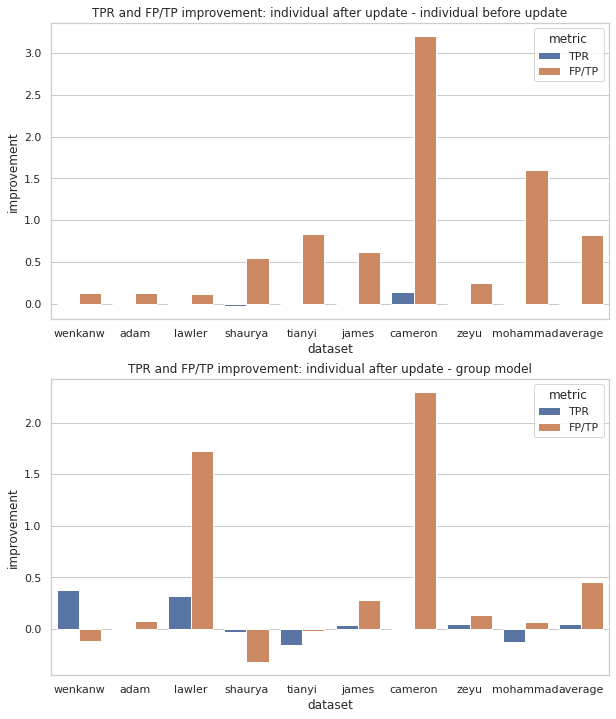

In [215]:
compute_improvement_v2(ind_perf_ratio,group_param_episode_perf,file_name = 'episode_improvement_ratio')

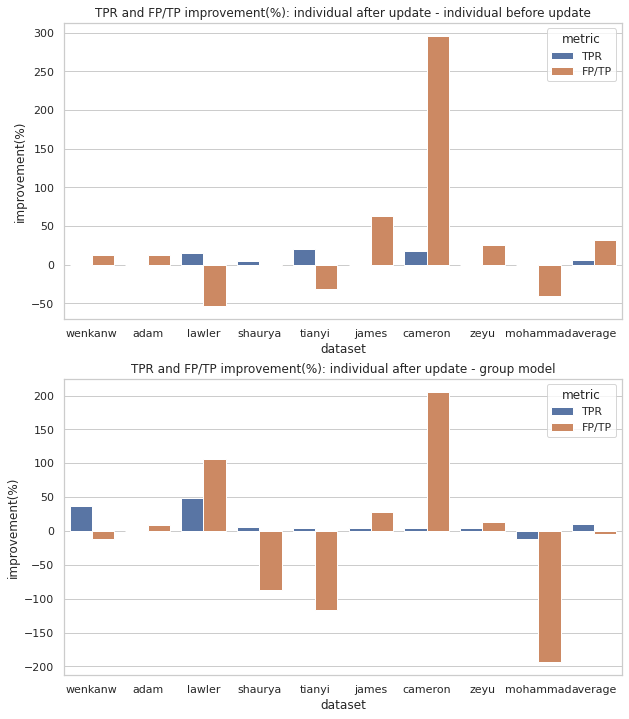

In [202]:
compute_improvement_v2(ind_perf_mtpr,group_param_episode_perf,file_name = 'episode_improvement_mtpr')

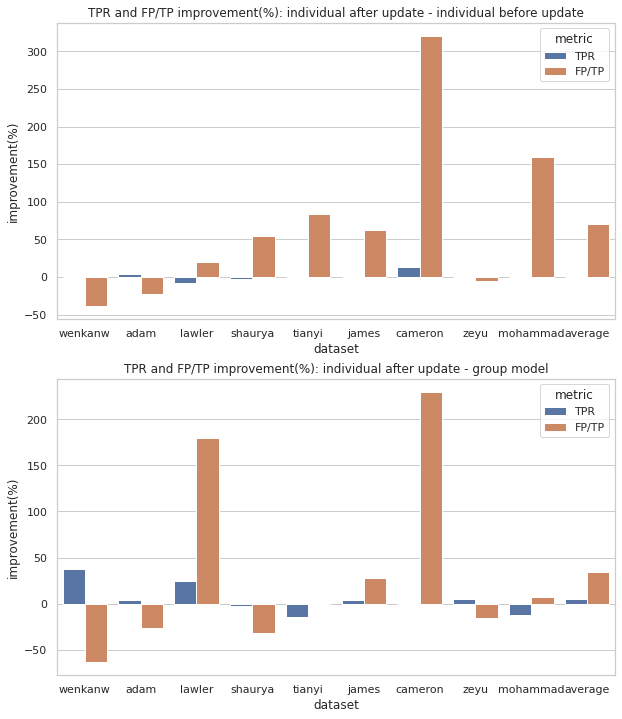

In [203]:
compute_improvement_v2(ind_perf_mfp,group_param_episode_perf,file_name = 'episode_improvement_mfp')

# After excluding some subjects

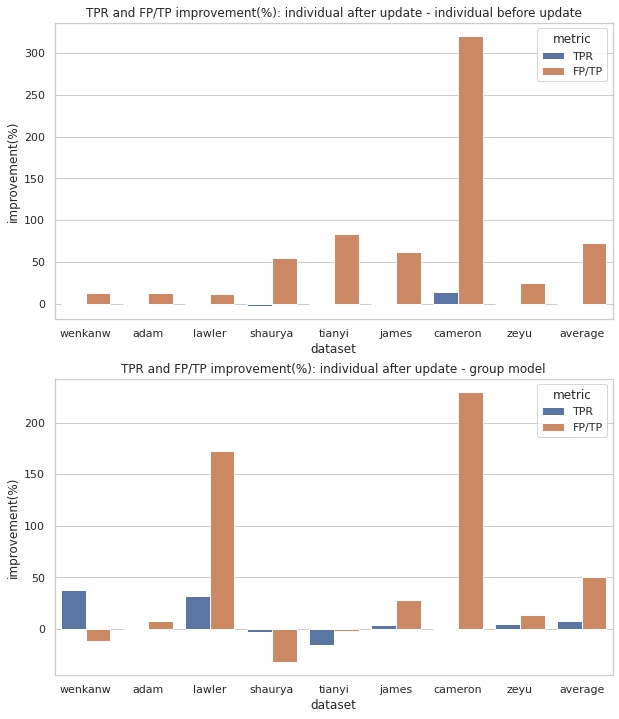

In [204]:
compute_improvement_v2(ind_perf_ratio_ex,group_param_episode_perf_ex,file_name = 'episode_improvement_ratio_ex')

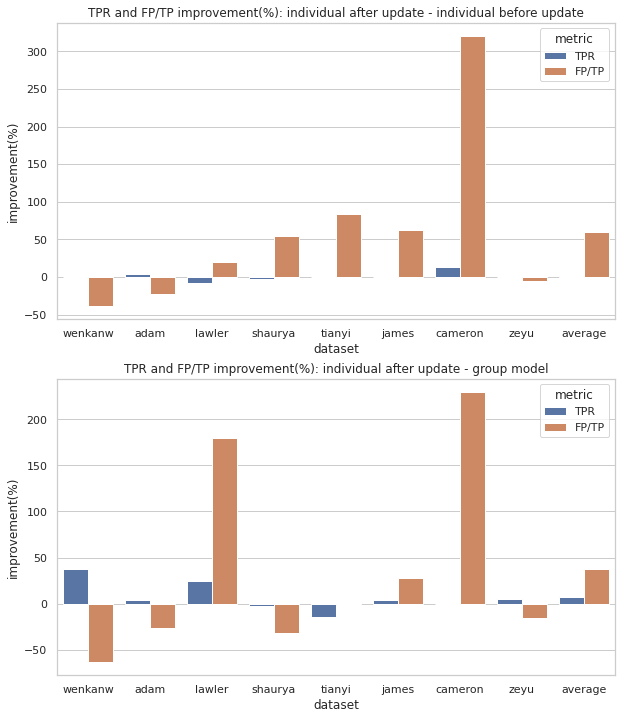

In [211]:
compute_improvement_v2(ind_perf_mfp_ex,group_param_episode_perf_ex,file_name = 'episode_improvement_mfp_ex')

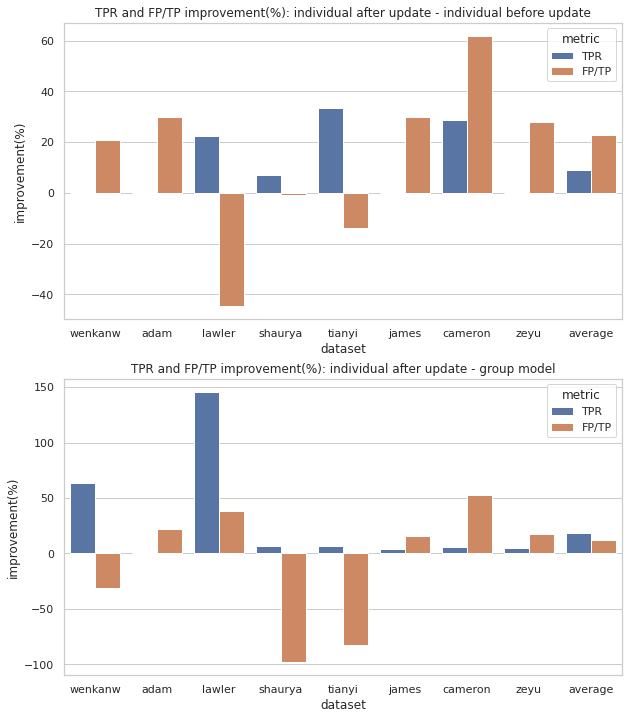

In [209]:
compute_improvement_v2(ind_perf_mtpr_ex,group_param_episode_perf_ex,file_name = 'episode_improvement_mtpr_ex',use_perc=True)

# Visualize Possibility Sequence

In [16]:
datasets = create_datasets(names = ['wenkanw'])

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

In [18]:
def generate_possibility(dataset,fold_num=5):
    """
    dataset: person_meal dataset
    output: generated possibility adn ground true label and prediction in episode
    """
    result = pd.DataFrame()
    from sklearn.model_selection import KFold
    days = np.unique(dataset.data_indices[:,0])
    kf = KFold(n_splits=5, random_state= 1000,shuffle=False)
    
    for fold, (day_train_idx, day_test_idx) in enumerate(kf.split(days)):
        day_test_idx = day_test_idx.tolist()
        proba_path ="../results/possibility_results/{}/cv_fold_{}_".format(dataset.person_name,fold)
        partial_result = hysteresis_threshold(None, dataset,days_ls = day_test_idx,start_threshold=0.8, end_threshold=0.4,
                                                  winmin = 6, stepsec=5, episode_min = 1.,
                                                 load_proba_flag=True, path =proba_path)
        #print(partial_result)
        result = result.append(partial_result,ignore_index=True)
    proba_ls, labels_ls, preds_ls =map_results(dataset,result)
    return proba_ls, labels_ls, preds_ls, result

In [19]:
proba_ls, labels_ls, preds_ls, result = generate_possibility(datasets['wenkanw'],fold_num=5)

100%|██████████| 3/3 [00:00<00:00, 446.20it/s]


Segmentation Completed. 
Segmentation Completed. 
Segmentation Completed. 
Segmentation Completed. 
Segmentation Completed. 


In [32]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt


def visualize_prob(offset,winsize,day, model_result="I",file_name ="possibility_seq", Ts= 0.8, Te= 0.4 ):
    stride  = 5 *15 # 5 seconds between two adjacent labels/window samples
    fig_path = "../results/images/"
    day = int(day)
    if model_result =="I":
        proba_list=proba_ls
        labels_list= labels_ls
        preds_list=preds_ls
    else:
        proba_list=proba_ls_g
        labels_list= labels_ls_g
        preds_list=preds_ls_g
    proba, labels, preds = proba_list[day], labels_list[day], preds_list[day]    
    
    offset = offset *15
    if winsize == -1:
        winsize = len(labels)
        offset = 0
    else:
        winsize = winsize*15
    
    if  len(labels)-winsize <0:
        #offset = len(labels)-winsize
        offset =0
        winsize = len(labels)
        
    t = np.arange(start = offset, stop= offset+winsize, step=1)
    print("Offset: ",offset, "winszie: ",winsize,"t shape: ",t.shape, "label shape:", labels.shape, preds.shape)
    fig, ax = plt.subplots(3,1,figsize= (20,12))
    df1 = proba[offset:offset+winsize]
    df2 = np.array(preds[offset:offset+winsize]) #*10-5
    df3 = np.array(labels[offset:offset+winsize])#*10-5
    
    x1= sns.lineplot(x=t, y=df1 , ax =ax[0],color= 'grey',label="Possibility")
    x2 = sns.lineplot(t,df2 , ax =ax[1],color='g', linewidth=1.5,label="Prediction(Eat)")
    x3 = sns.lineplot(t,df3 , ax =ax[2],color='b', linewidth=1.5, label="Label(Eat)")
        
    
        
    ax[0].fill_between( t, df1, 
                interpolate=True, color='grey')
    
    ax[0].fill_between(t, df3, where=(df3==1), 
                interpolate=True, color='blue')
    ax[0].fill_between( t,df2, where=(df2==1), 
                interpolate=True, color='green')
    ax[0].set_ylim(0,1)
    print(offset,len(labels)-winsize )
    if offset >= len(labels)-winsize:
        title_txt ="Day: "+ str(day) + " Whole Day samples: "+str(len(labels)) +" . " + "Sample plotted: "+str(winsize)+". "
    else:
        title_txt = "Day: "+ str(day) + " Samples from "+str(offset) +"~" + str((offset+winsize)) +". "+ "Number of Sample plotted: "+str(winsize)+". "
    title_txt += " Ts = {}, Te ={}".format(Ts, Te)
    ax[0].set_title(title_txt)
    ax[2].set_xlabel("index of sample")
    ax[0].set_ylabel("Possibility")
    ax[1].set_ylabel("Predictions")
    ax[2].set_ylabel("Ground Truch")
    
    ax[0].legend(["Possibility"],loc='upper left')
    ax[1].legend(["1: Eat, 0:Other"],loc='upper left')
    ax[2].legend(["1: Eat, 0:Other"],loc='upper left')
    x3 = x3.get_figure()
    x3.savefig(fig_path+file_name, dpi = 80)
    return 

Offset:  0 winszie:  54000 t shape:  (54000,) label shape: (427959,) (427959,)
0 373959


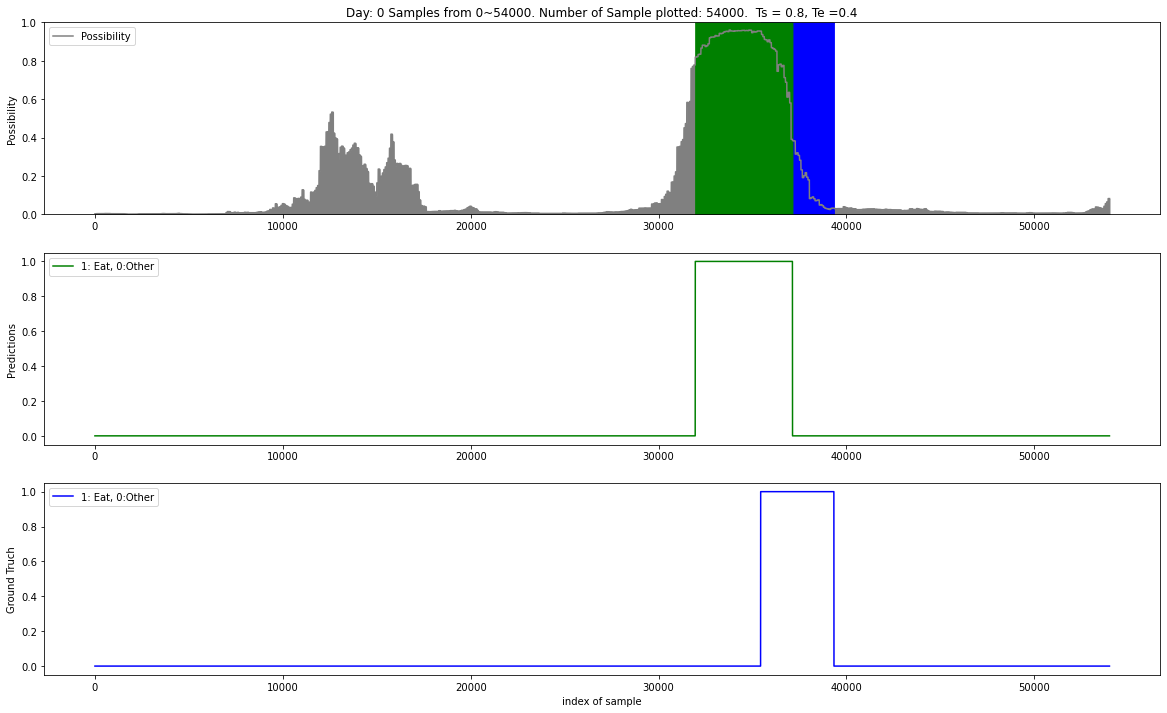

In [33]:
visualize_prob(offset=0,winsize=3600,day=0, model_result="I",file_name ="possibility_seq" )

In [394]:

# style = {'description_width': 'initial'}
# bound_text = widgets.BoundedIntText(
#     value=0,
#     min=0,
#     max=10*3600,
#     step=1,
#     description='offset(sec):[0~'+ str(10*3600)+"]",
#     disabled=False,
#     style = {'description_width': 'initial'}
# )
# slidebar= widgets.IntSlider(min=0, max=len(result.proba.iloc[0]), step=1, value=0)
# winsize = widgets.Dropdown(
#     options=[-1, 60,60*60],
#     value=-1,
#     description='Num of sec plotted ',
#     disabled=False,
#     style = style
# )

# interact(f, offset=bound_text, winsize= winsize, day = '0',model_result= "I");